In [15]:
from __future__ import annotations

from pathlib import Path

from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.dates as mdates

In [16]:
# Configuración global
from pandas.api.types import CategoricalDtype
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 110

# Montar drive y fija la ruta base
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH  = Path("/content/drive/MyDrive/ProyectoIntegrador/ModeloPronosticos/data")
CLEAN_PATH = BASE_PATH / "cleaned"
CLEAN_PATH.mkdir(parents=True, exist_ok=True)

MISSING_COL_THRESHOLD = 0.30   # descartar columnas con >30 % de nulos
HIGH_CARDINALITY_K    = 20     # top-k categorías a conservar
HIGH_CORR_THRESHOLD   = 0.90   # |ρ| crítico para multicolinealidad
LOW_VAR_THRESHOLD     = 1e-4   # varianza ~0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Utilidades de pre-procesamiento
def imputar_nulos(df: pd.DataFrame) -> pd.DataFrame:
    """Imputa nulos (numéricas → mediana, categóricas → moda)."""
    df = df.copy()
    num = df.select_dtypes("number").columns
    cat = df.select_dtypes(include=["object", "category"]).columns
    if num.any():
        df[num] = df[num].fillna(df[num].median())
    if cat.any():
        df[cat] = df[cat].apply(lambda s: s.fillna(s.mode().iloc[0]))
    return df

In [18]:
# Winsorización de outliers
def winsorizar_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """Corta valores fuera de 1.5·IQR (excepto Year, Mes, AnioArchivo)."""
    df = df.copy()
    num = [c for c in df.select_dtypes("number")
           if c.lower() not in {"year", "mes", "anioarchivo", "añoarchivo"}]
    if not num:
        return df
    q1 = df[num].quantile(.25)
    q3 = df[num].quantile(.75)
    iqr = q3 - q1
    df[num] = df[num].clip(lower=q1 - 1.5 * iqr, upper=q3 + 1.5 * iqr, axis=1)
    return df

In [19]:
# Reducción de cardinalidad
def reducir_cardinalidad(df: pd.DataFrame,
                         k: int = HIGH_CARDINALITY_K) -> pd.DataFrame:
    """Agrupa categorías poco frecuentes en «OTROS» (sólo top-k)."""
    df = df.copy()

    for col in df.select_dtypes(include=["object", "category"]):
        if df[col].nunique() > k:
            top_k = df[col].value_counts().nlargest(k).index

            # Añade la categoría «OTROS» si la serie ya es Categorical
            if isinstance(df[col].dtype, CategoricalDtype) and "OTROS" not in df[col].cat.categories:
              df[col] = df[col].cat.add_categories(["OTROS"])

            df[col] = df[col].where(df[col].isin(top_k), "OTROS")

    return df

In [20]:
# Corrección de sesgo
def transformar_sesgo(df: pd.DataFrame) -> pd.DataFrame:
    """Aplica log10 a numéricas con |skew| > 1 (todas > 0)."""
    df = df.copy()
    num = df.select_dtypes("number")
    sesgadas = [c for c in num if abs(num[c].skew()) > 1 and (num[c] > 0).all()]
    if sesgadas:
        df[sesgadas] = np.log10(df[sesgadas] + 1e-9)
    return df

In [21]:
# Seleccionar features
def seleccionar_features(df: pd.DataFrame) -> List[str]:
    """Devuelve lista de columnas tras quitar varianza~0 y ρ > 0.90."""
    df_num = df.select_dtypes("number")
    df_num = df_num.loc[:, df_num.var() > LOW_VAR_THRESHOLD]

    corr   = df_num.corr().abs()
    upper  = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop   = [c for c in upper.columns if (upper[c] > HIGH_CORR_THRESHOLD).any()]

    return (df_num.columns.difference(drop).tolist() +
            df.select_dtypes(include=["object", "category"]).columns.tolist())

In [22]:
# Visualización & diagnóstico
def plot_hist_box(df: pd.DataFrame, col: str, title: str, *, show=True) -> None:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[col], kde=True, ax=ax[0]); ax[0].set_title(f"Hist – {title}")
    sns.boxplot(x=df[col], ax=ax[1]);          ax[1].set_title("Box-plot")
    plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.close(fig)

In [23]:
# Gráfica de tendencia temporal
def tendencia_temporal(df: pd.DataFrame, fecha: str, y: str, title: str,
                       *, show=True) -> None:
    grp = df.groupby(fecha)[y].sum().reset_index()
    fig = plt.figure(figsize=(12, 4))
    sns.lineplot(data=grp, x=fecha, y=y)
    plt.title(title); plt.xticks(rotation=45); plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.close(fig)

In [24]:
# Matriz de correlación
def matriz_correlacion(df: pd.DataFrame, cols: List[str], *, show=True) -> None:
    fig = plt.figure(figsize=(6, 5))
    sns.heatmap(df[cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Mapa de correlaciones"); plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.close(fig)

In [25]:
# Pipeline de EDA
def eda_completo(df: pd.DataFrame,
                 nombre: str,
                 fecha_col: str | None = None,
                 valor_col: str | None = None,
                 *,
                 plot: bool = True) -> Tuple[pd.DataFrame, List[str]]:
    """
    ▸ Diagnóstico + visualizaciones · ▸ Pre-procesamiento · ▸ Selección de
    variables · ▸ Exportación de artefactos.  Devuelve (df_limpio, features).
    """
    print(f"\n{'='*10} EDA – {nombre} {'='*10}\nForma inicial:", df.shape)
    # Agrupar categorías idénticas (cosmético)
    print(df.dtypes.apply(str).value_counts().sort_index())

    # Nulos
    nulls = df.isna().mean()
    print("\n% nulos por columna:\n", (nulls * 100).round(2))
    if plot and nulls.any():
        sns.heatmap(df.isna(), cbar=False)
        plt.title("Mapa de valores faltantes"); plt.tight_layout(); plt.show()

    # Desequilibrio categórico
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    for col in cat_cols:
        ratio = df[col].value_counts(normalize=True).iloc[0]
        print(f"Max proporción en {col}: {ratio:.2%}")

    # Stats
    try:
        desc = df.describe(include="all", datetime_is_numeric=True)
    except TypeError:                      # pandas < 1.5
        desc = df.describe(include="all")
    print("\nResumen descriptivo:\n", desc)

    if cat_cols.any():
        print("\nCardinalidad categóricas:\n", df[cat_cols].nunique())
        if plot:
            for col in cat_cols:
                df[col].value_counts().head(20).plot(kind="bar", figsize=(8, 4))
                plt.title(f"Frecuencia {col}")
                plt.show()

    # Plots numéricos
    if plot and valor_col in df.columns:
        plot_hist_box(df, valor_col, valor_col)
    if plot and fecha_col and valor_col and fecha_col in df.columns:
        tendencia_temporal(df, fecha_col, valor_col,
                           f"Tendencia temporal {valor_col}")

    num_cols = df.select_dtypes("number").columns
    if plot and len(num_cols) >= 2:
        matriz_correlacion(df, list(num_cols))

    # ── Pre-procesamiento
    df_clean = df.copy()
    if nulls.gt(MISSING_COL_THRESHOLD).any():
        drop_cols = nulls[nulls > MISSING_COL_THRESHOLD].index
        print("\nEliminando columnas con >30 % nulos:", list(drop_cols))
        df_clean.drop(columns=drop_cols, inplace=True)

    df_clean = (df_clean
                .pipe(imputar_nulos)
                .pipe(winsorizar_outliers)
                .pipe(reducir_cardinalidad)
                .pipe(transformar_sesgo))

    # Selección de variables
    selected = seleccionar_features(df_clean)
    print(f"\nVariables retenidas ({len(selected)}):\n", selected)

    # Guardar artefactos
    CLEAN_PATH.mkdir(exist_ok=True)
    out_file = CLEAN_PATH / f"{nombre.replace(' ','_').lower()}_clean.csv"
    df_clean.to_csv(out_file, index=False)
    print("Dataset limpio guardado en:", out_file.relative_to(BASE_PATH.parent))

    print("\nConclusiones:",
          f"\n- Filas tras limpieza: {df_clean.shape[0]}",
          f"\n- Numéricas: {len(df_clean.select_dtypes('number').columns)}",
          f"\n- Categóricas: {len(df_clean.select_dtypes(include=['object', 'category']).columns)}",
          sep=" ")

    return df_clean, selected

In [26]:
#Función principal
def main(plot: bool = True) -> None:
    """Ejecuta el pipeline EDA sobre cada uno de los archivos CRT."""
    files = {
        "Exportaciones Total Forma"   : "consolidado_exportacionestotalforma.csv",
        "Exportaciones Total Categoría": "consolidado_exportacionestotalcategoria.csv",
        "Producción Total Tequila"    : "consolidado_producciontotaltequila.csv",
        "Consumo de Agave Total"      : "consolidado_consumodeagavetotal.csv",
        "Exportaciones País"          : "consolidado_exportaciones_pais.csv",
    }

    for nombre, fname in files.items():
        df = pd.read_csv(BASE_PATH / fname)

        # Normalizar nombre Año → AnioArchivo
        df.rename(columns={"AñoArchivo": "AnioArchivo",
                           "A\u00F1oArchivo": "AnioArchivo"}, inplace=True)

        # Filtrar duplicados “Total”
        if "SubCategoria" in df.columns:
            df = df[~df["SubCategoria"].str.contains("total", case=False)]

        # Convertir categóricas a dtype category (ahorra RAM)
        cat_cols = df.select_dtypes("object").columns
        df[cat_cols] = df[cat_cols].astype("category")

        # Crear columna Fecha y determinar métrica
        fecha_col, valor_col = None, None
        if {"AnioArchivo", "Mes"}.issubset(df.columns):
            df = df.assign(
                Fecha=pd.to_datetime(
                    {"year": df["AnioArchivo"], "month": df["Mes"], "day": 1})
            )
            fecha_col = "Fecha"

        valor_col = "Valor" if "Valor" in df.columns else "Total_Pais_Mes"

        eda_completo(df, nombre, fecha_col, valor_col, plot=plot)


========== EDA – Exportaciones Total Forma ==========
Forma inicial: (726, 6)
category          1
datetime64[ns]    1
float64           1
int64             3
Name: count, dtype: int64

% nulos por columna:
 SubCategoria    0.0
Year            0.0
Valor           0.0
AnioArchivo     0.0
Mes             0.0
Fecha           0.0
dtype: float64
Max proporción en SubCategoria: 50.00%

Resumen descriptivo:
        SubCategoria         Year       Valor  AnioArchivo         Mes  \
count           726   726.000000  726.000000   726.000000  726.000000   
unique            2          NaN         NaN          NaN         NaN   
top        Envasado          NaN         NaN          NaN         NaN   
freq            363          NaN         NaN          NaN         NaN   
mean            NaN  2009.628099    7.431956  2009.628099    6.462810   
min             NaN  1995.000000    0.400000  1995.000000    1.000000   
25%             NaN  2002.000000    4.500000  2002.000000    3.000000   
50%        

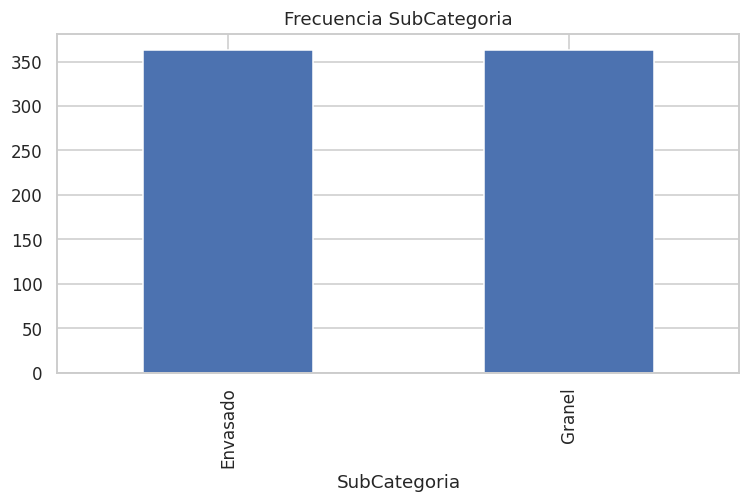

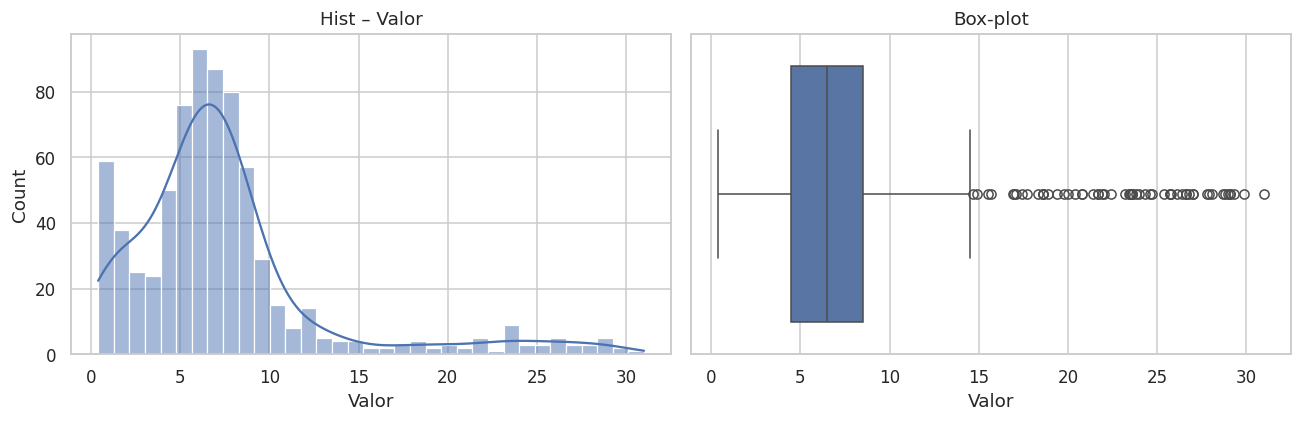

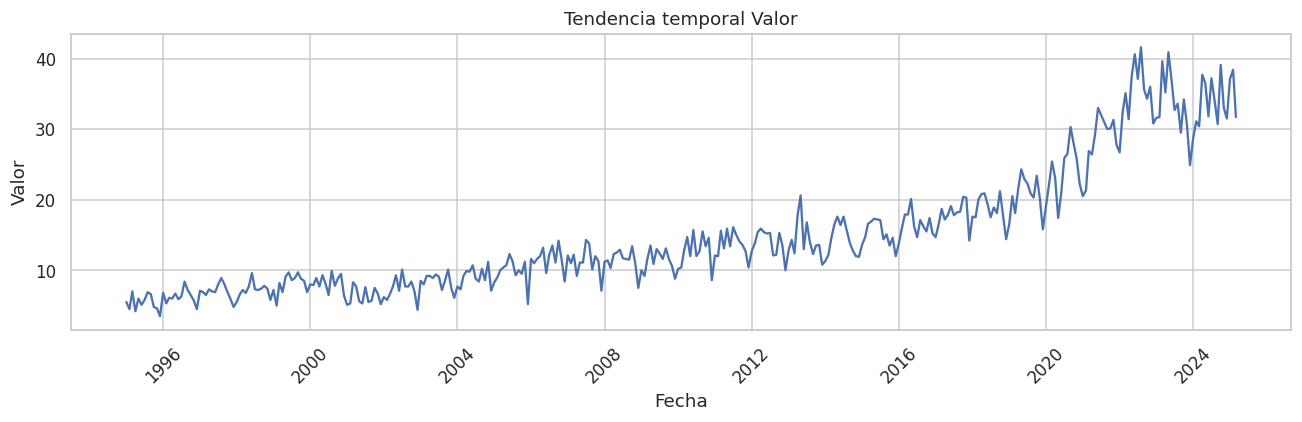

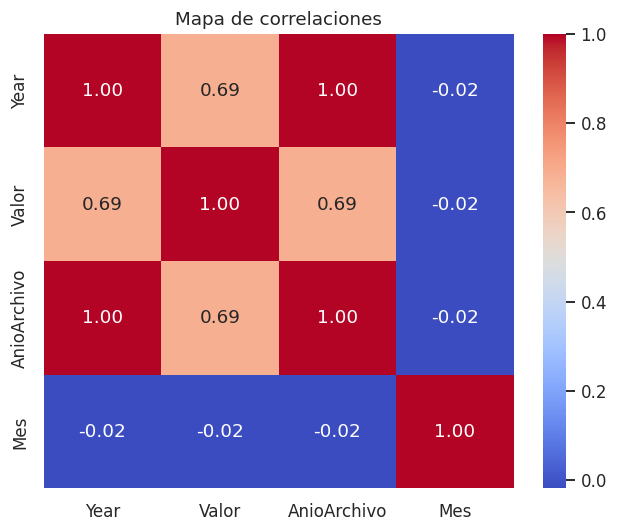


Variables retenidas (4):
 ['Mes', 'Valor', 'Year', 'SubCategoria']
Dataset limpio guardado en: data/cleaned/exportaciones_total_forma_clean.csv

Conclusiones: 
- Filas tras limpieza: 726 
- Numéricas: 4 
- Categóricas: 1

========== EDA – Exportaciones Total Categoría ==========
Forma inicial: (726, 6)
category          1
datetime64[ns]    1
float64           1
int64             3
Name: count, dtype: int64

% nulos por columna:
 SubCategoria    0.0
Year            0.0
Valor           0.0
AnioArchivo     0.0
Mes             0.0
Fecha           0.0
dtype: float64
Max proporción en SubCategoria: 50.00%

Resumen descriptivo:
        SubCategoria         Year       Valor  AnioArchivo         Mes  \
count           726   726.000000  726.000000   726.000000  726.000000   
unique            2          NaN         NaN          NaN         NaN   
top         Tequila          NaN         NaN          NaN         NaN   
freq            363          NaN         NaN          NaN         NaN   
mean

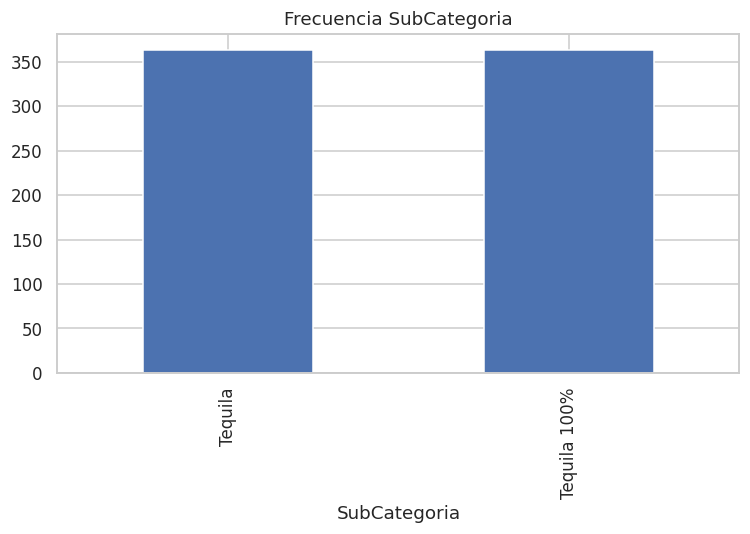

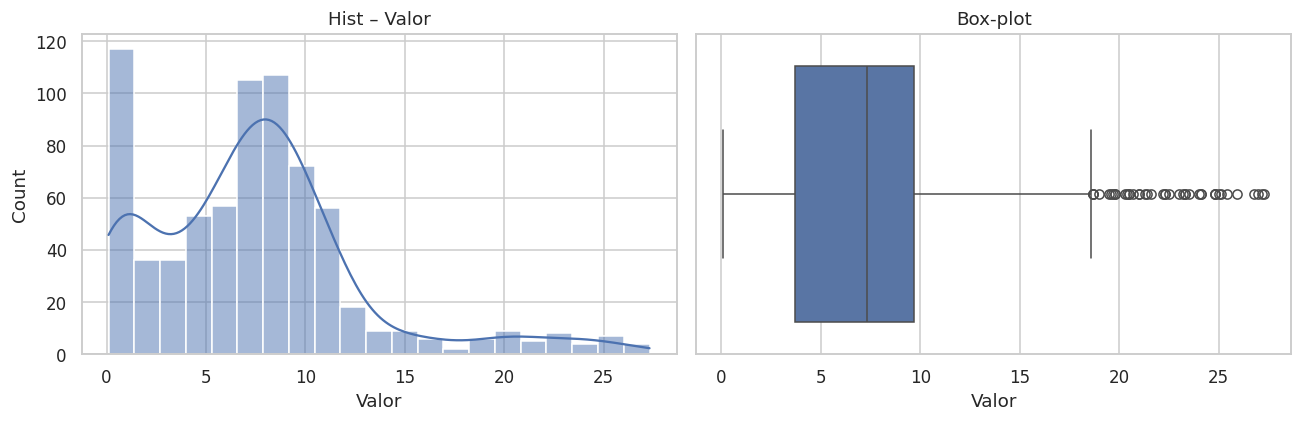

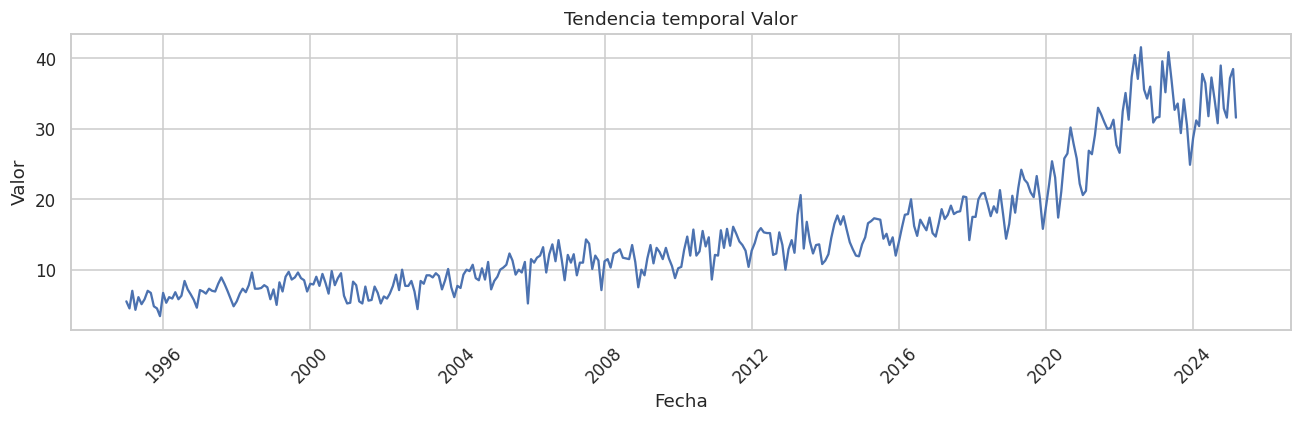

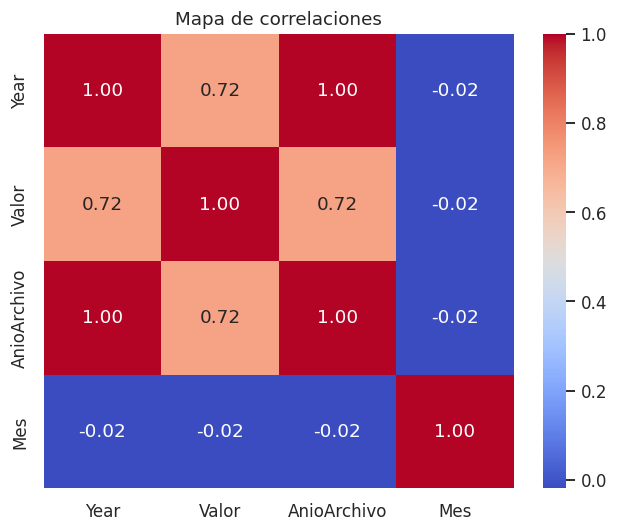


Variables retenidas (4):
 ['Mes', 'Valor', 'Year', 'SubCategoria']
Dataset limpio guardado en: data/cleaned/exportaciones_total_categoría_clean.csv

Conclusiones: 
- Filas tras limpieza: 726 
- Numéricas: 4 
- Categóricas: 1

========== EDA – Producción Total Tequila ==========
Forma inicial: (724, 6)
category          1
datetime64[ns]    1
float64           1
int64             3
Name: count, dtype: int64

% nulos por columna:
 SubCategoria    0.0
Year            0.0
Valor           0.0
AnioArchivo     0.0
Mes             0.0
Fecha           0.0
dtype: float64
Max proporción en SubCategoria: 50.00%

Resumen descriptivo:
        SubCategoria         Year       Valor  AnioArchivo         Mes  \
count           724   724.000000  724.000000   724.000000  724.000000   
unique            2          NaN         NaN          NaN         NaN   
top         Tequila          NaN         NaN          NaN         NaN   
freq            362          NaN         NaN          NaN         NaN   
mean 

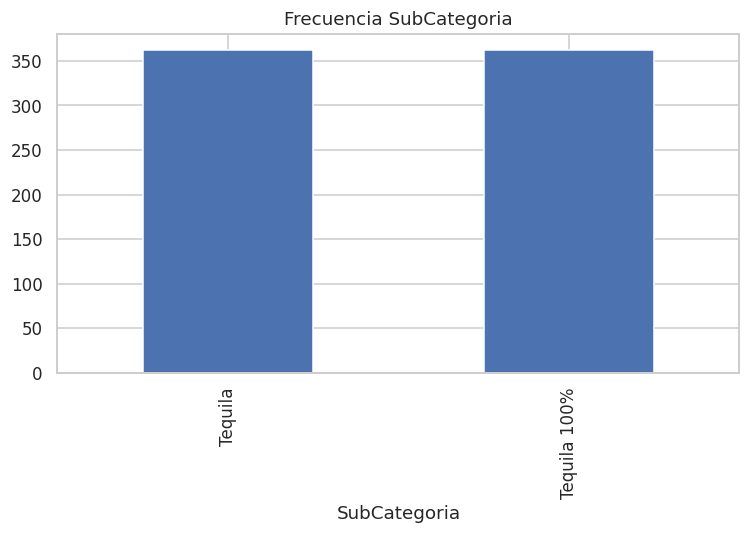

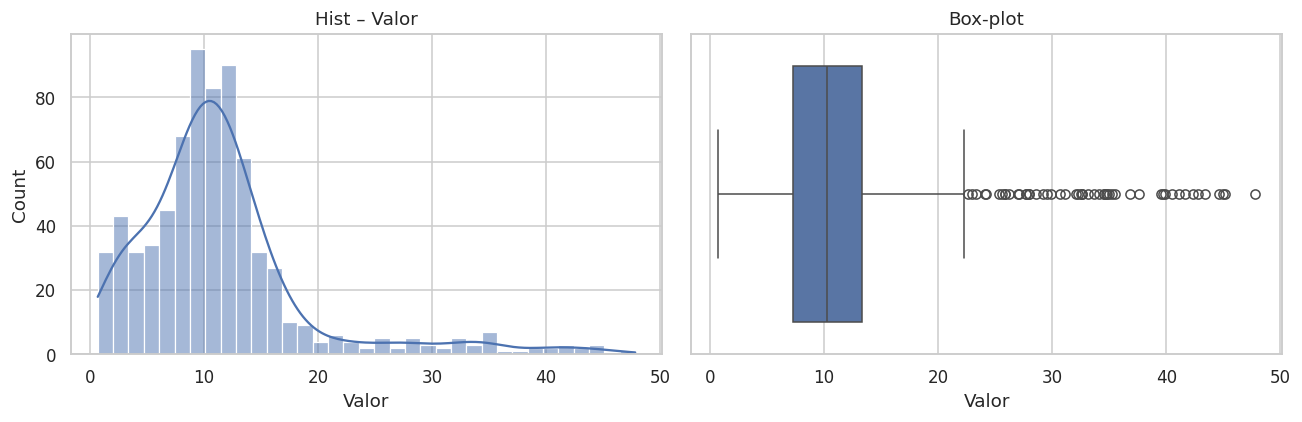

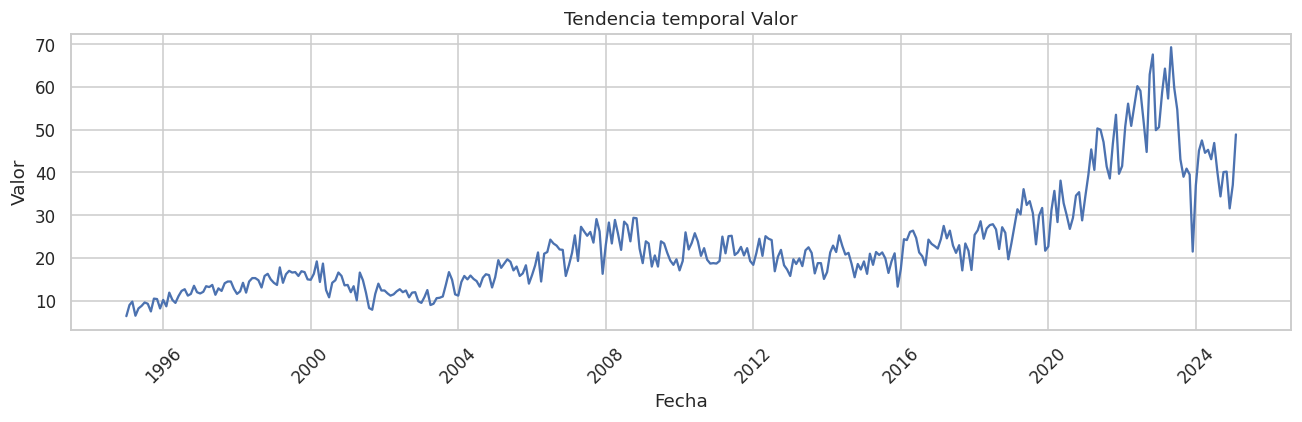

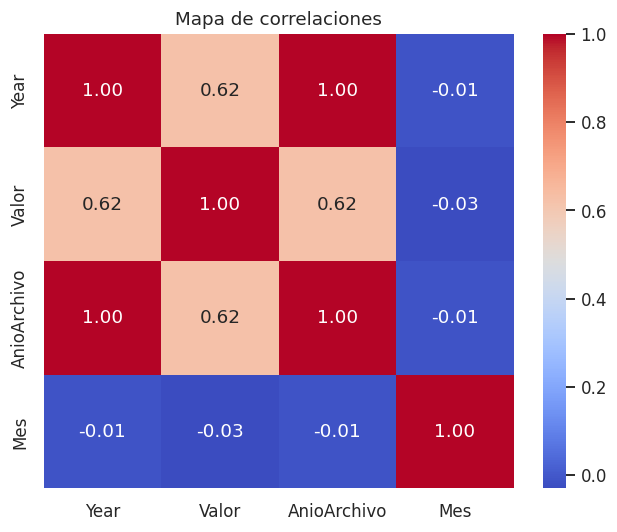


Variables retenidas (4):
 ['Mes', 'Valor', 'Year', 'SubCategoria']
Dataset limpio guardado en: data/cleaned/producción_total_tequila_clean.csv

Conclusiones: 
- Filas tras limpieza: 724 
- Numéricas: 4 
- Categóricas: 1

========== EDA – Consumo de Agave Total ==========
Forma inicial: (724, 6)
category          1
datetime64[ns]    1
float64           1
int64             3
Name: count, dtype: int64

% nulos por columna:
 SubCategoria    0.0
Year            0.0
Valor           0.0
AnioArchivo     0.0
Mes             0.0
Fecha           0.0
dtype: float64
Max proporción en SubCategoria: 50.00%

Resumen descriptivo:
        SubCategoria         Year       Valor  AnioArchivo         Mes  \
count           724   724.000000  724.000000   724.000000  724.000000   
unique            2          NaN         NaN          NaN         NaN   
top         Tequila          NaN         NaN          NaN         NaN   
freq            362          NaN         NaN          NaN         NaN   
mean        

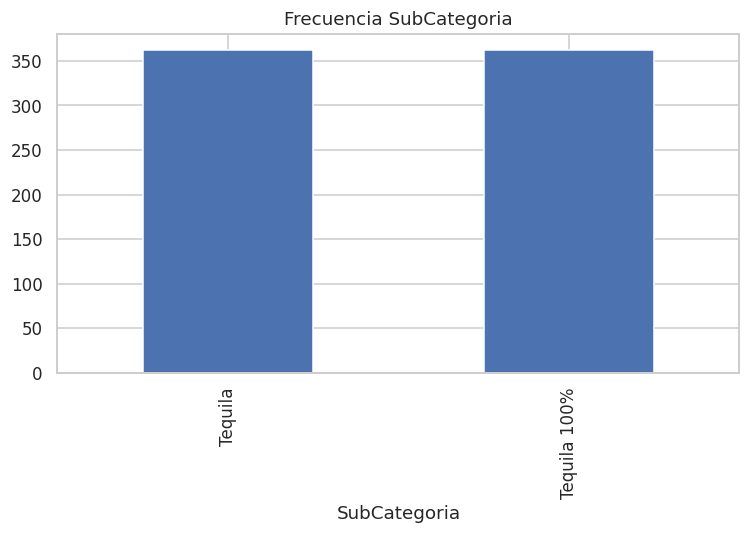

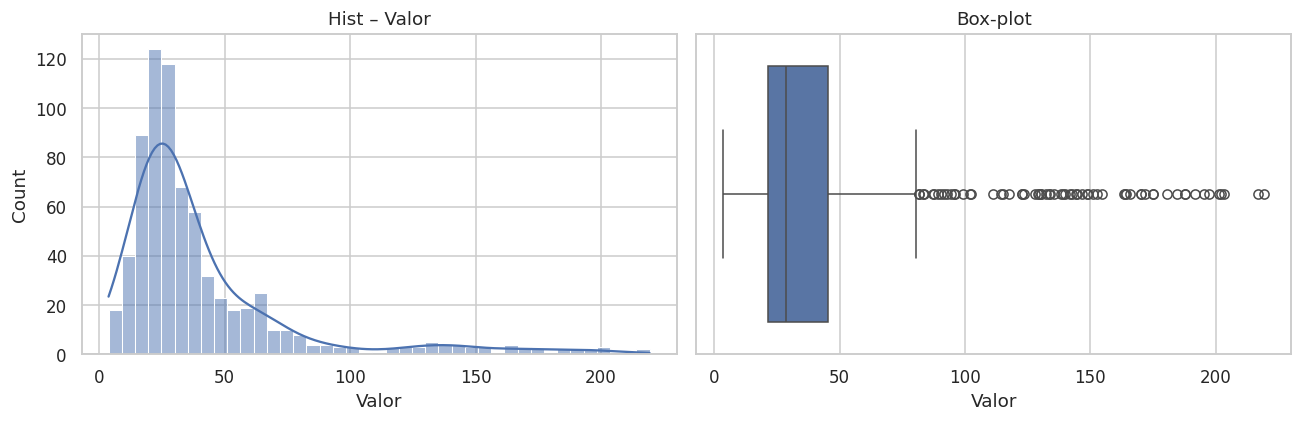

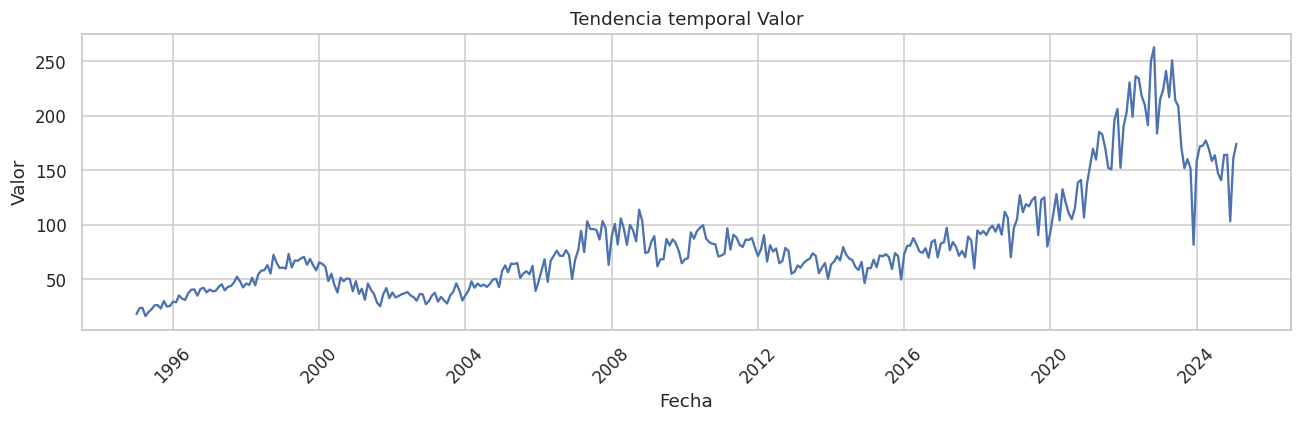

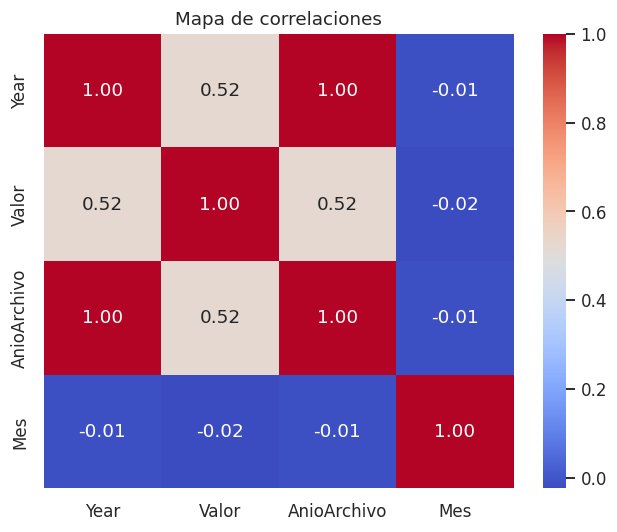


Variables retenidas (4):
 ['Mes', 'Valor', 'Year', 'SubCategoria']
Dataset limpio guardado en: data/cleaned/consumo_de_agave_total_clean.csv

Conclusiones: 
- Filas tras limpieza: 724 
- Numéricas: 4 
- Categóricas: 1

========== EDA – Exportaciones País ==========
Forma inicial: (64281, 9)
category          3
datetime64[ns]    1
float64           3
int64             2
Name: count, dtype: int64

% nulos por columna:
 NombrePais              0.0
Total_Pais_Mes          0.0
Categoria               0.0
Total_Categoria_Mes     0.0
Clase                   0.0
Litros 40 % Alc. Vol    0.0
AnioArchivo             0.0
Mes                     0.0
Fecha                   0.0
dtype: float64
Max proporción en NombrePais: 4.33%
Max proporción en Categoria: 50.22%
Max proporción en Clase: 33.40%

Resumen descriptivo:
                        NombrePais  Total_Pais_Mes              Categoria  \
count                       64281    6.428100e+04                  64281   
unique                        14

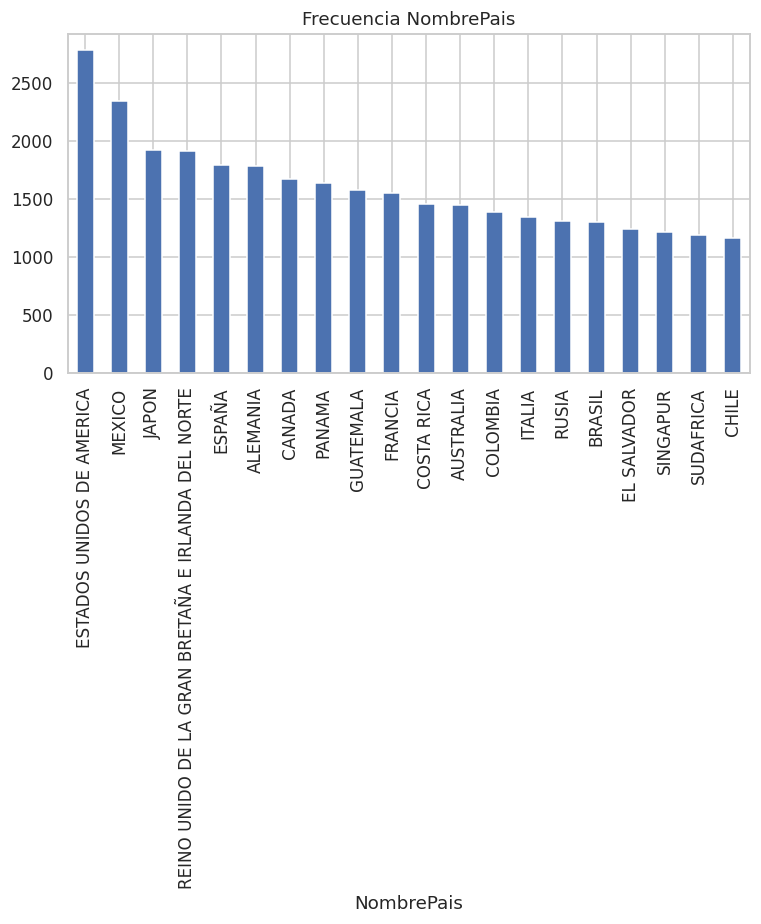

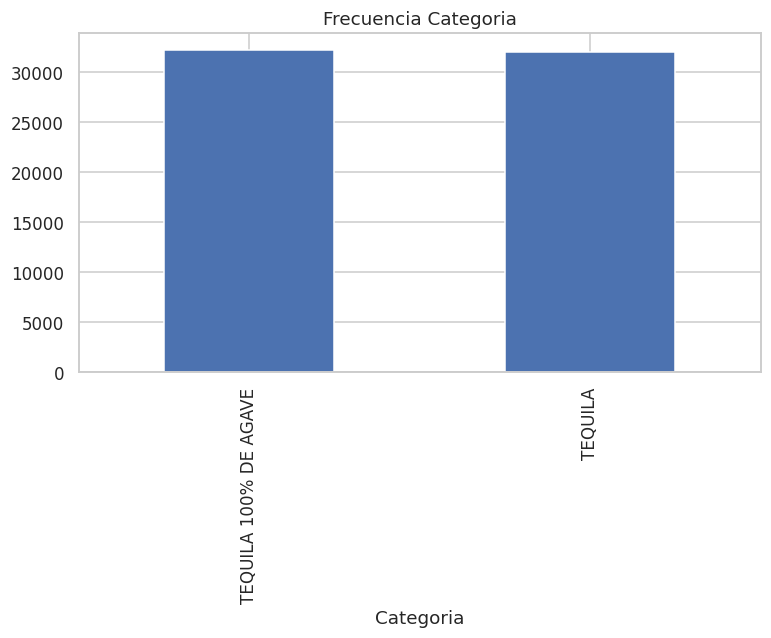

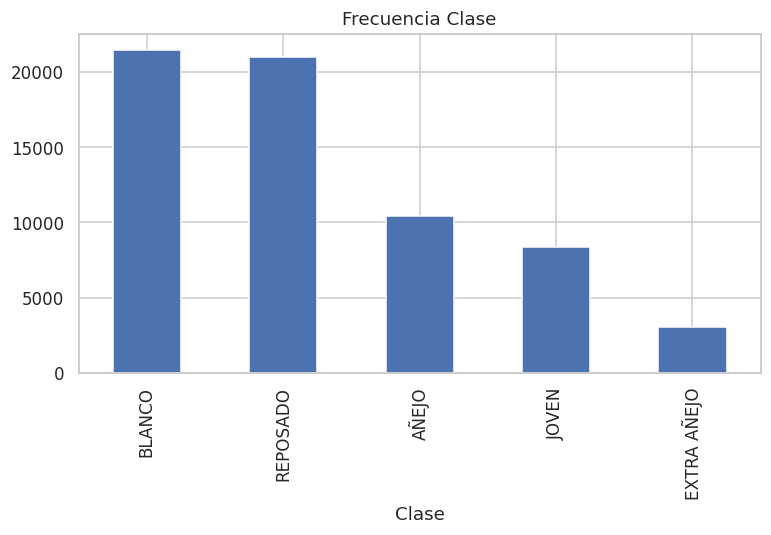

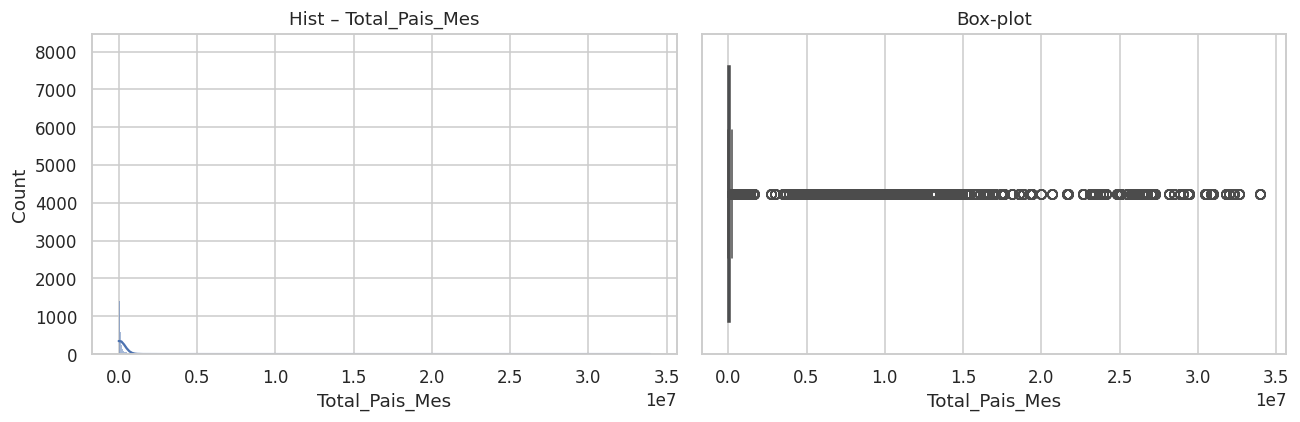

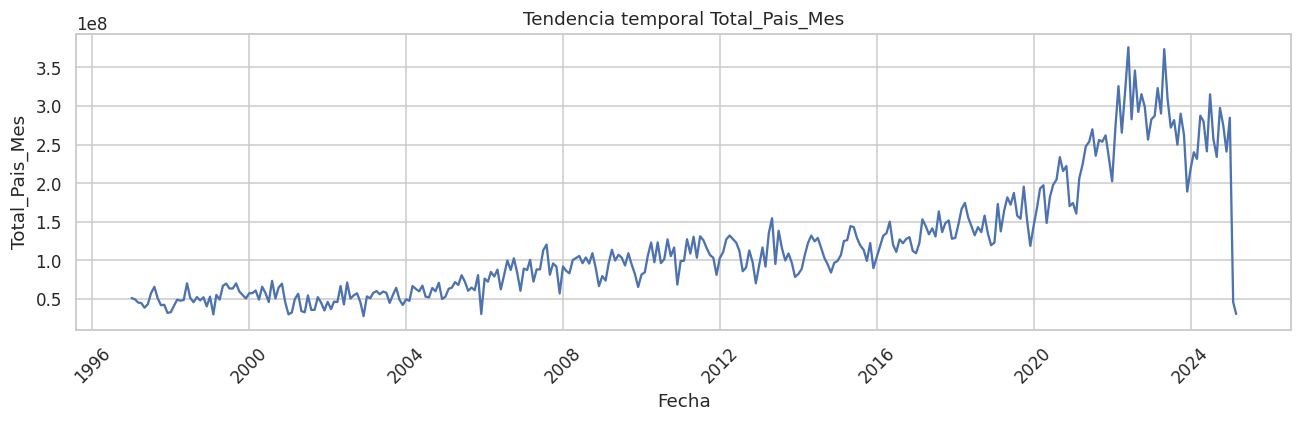

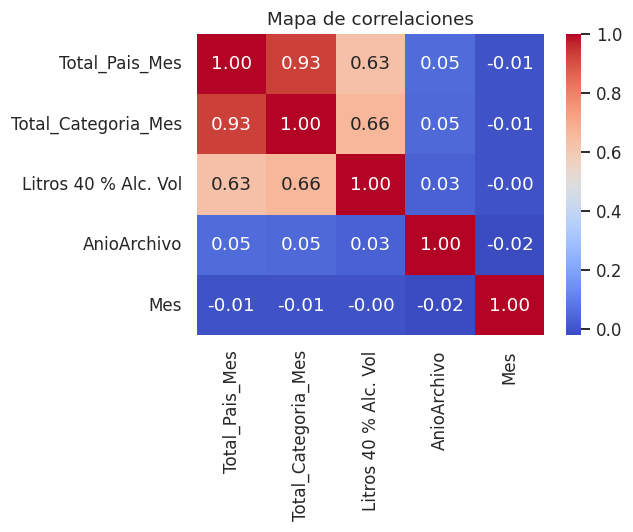


Variables retenidas (8):
 ['Total_Pais_Mes', 'Total_Categoria_Mes', 'Litros 40 % Alc. Vol', 'AnioArchivo', 'Mes', 'NombrePais', 'Categoria', 'Clase']
Dataset limpio guardado en: data/cleaned/exportaciones_país_clean.csv

Conclusiones: 
- Filas tras limpieza: 64281 
- Numéricas: 5 
- Categóricas: 3


In [27]:
if __name__ == "__main__":
    main(plot=True)

# Exportaciones totales por categoría

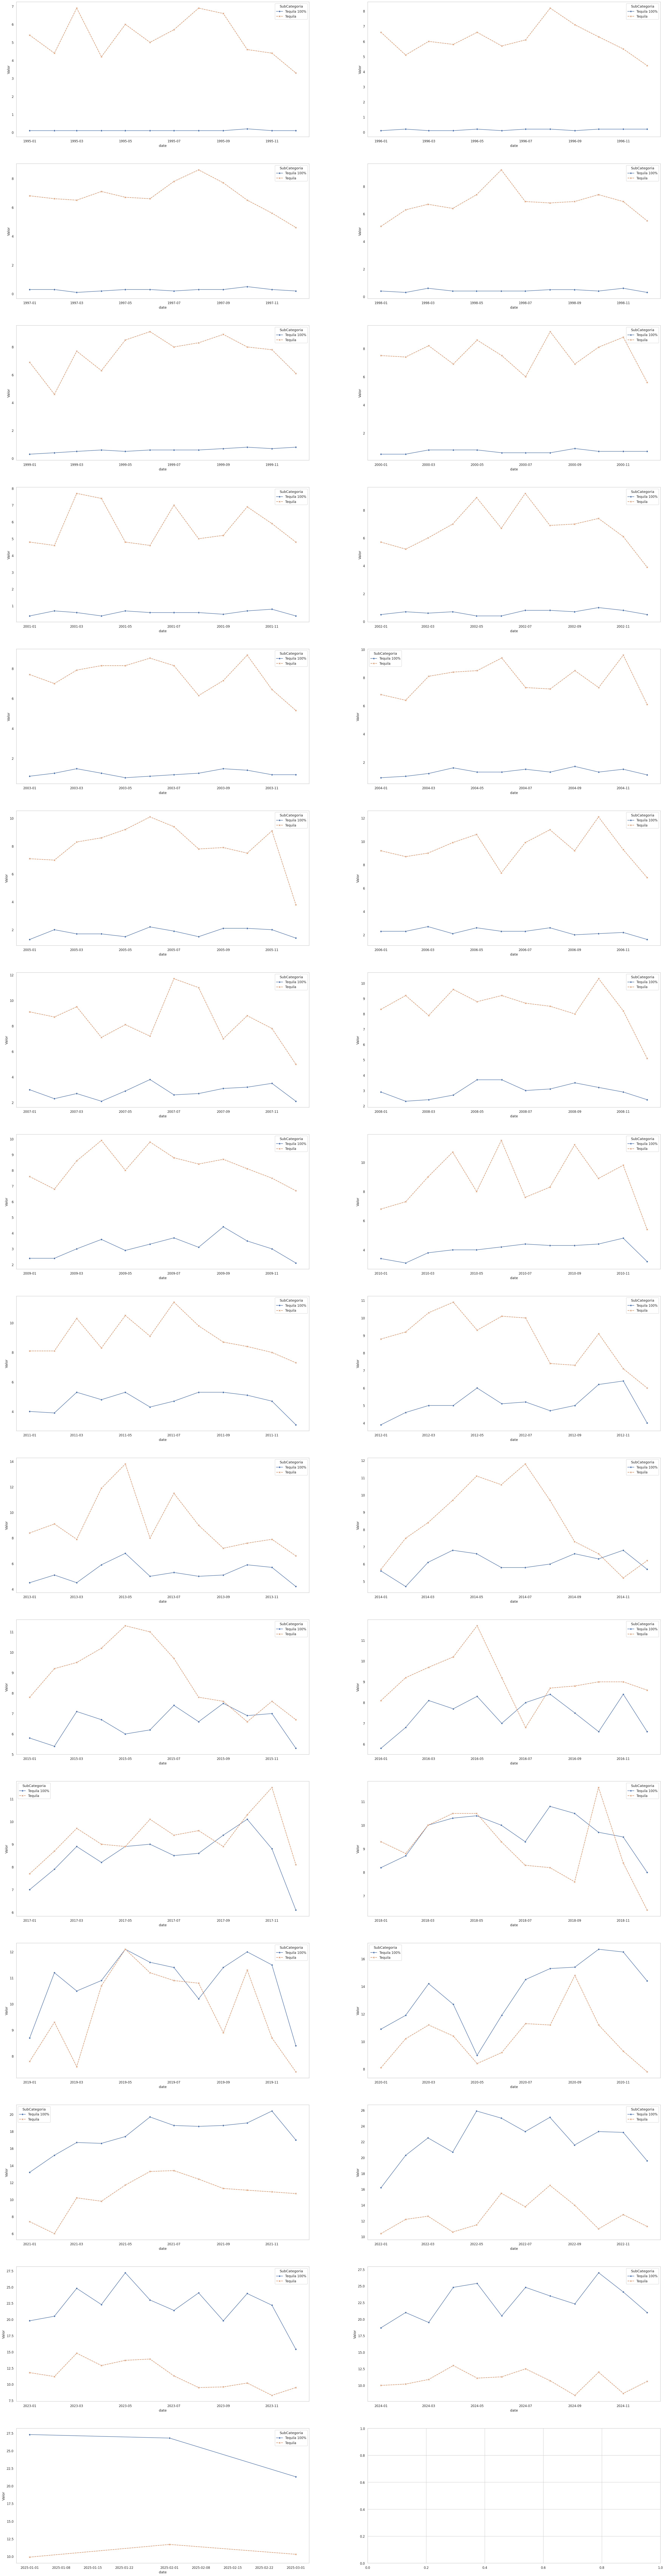

In [28]:
exportaciones_cat_df = pd.read_csv(BASE_PATH / "consolidado_exportacionestotalcategoria.csv")
exportaciones_cat_df["date"] = exportaciones_cat_df["Year"].astype(str) + "-" + exportaciones_cat_df["Mes"].astype(str) + "-1"
exportaciones_cat_df["date"] = exportaciones_cat_df["date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
exportaciones_cat_df["month"] = exportaciones_cat_df["date"].map(lambda x: x.strftime("%b"))

dfWithoutTotals = exportaciones_cat_df[exportaciones_cat_df["SubCategoria"] != "Total"]

cols = dfWithoutTotals["Year"].unique().tolist()
totalPlotColumns = 2
totalPlotRows = math.ceil(len(cols) / totalPlotColumns)
i = 0
j = 0
fig, axes = plt.subplots(totalPlotRows, totalPlotColumns, figsize=(20 * totalPlotColumns, 10 * totalPlotRows))

for indx, year in enumerate(cols):
    i = math.floor(((indx) / totalPlotColumns))
    j = indx % totalPlotColumns
    sns.lineplot(data=dfWithoutTotals[dfWithoutTotals["Year"] == year], x="date", y="Valor", hue="SubCategoria", style="SubCategoria", markers=True, ax=axes[i, j])
    loc = mdates.AutoDateLocator()
    axes[i, j].xaxis.set_major_locator(loc)
    axes[i, j].xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    axes[i, j].grid()

# Historial de exportaciones de tequila a estados unidos

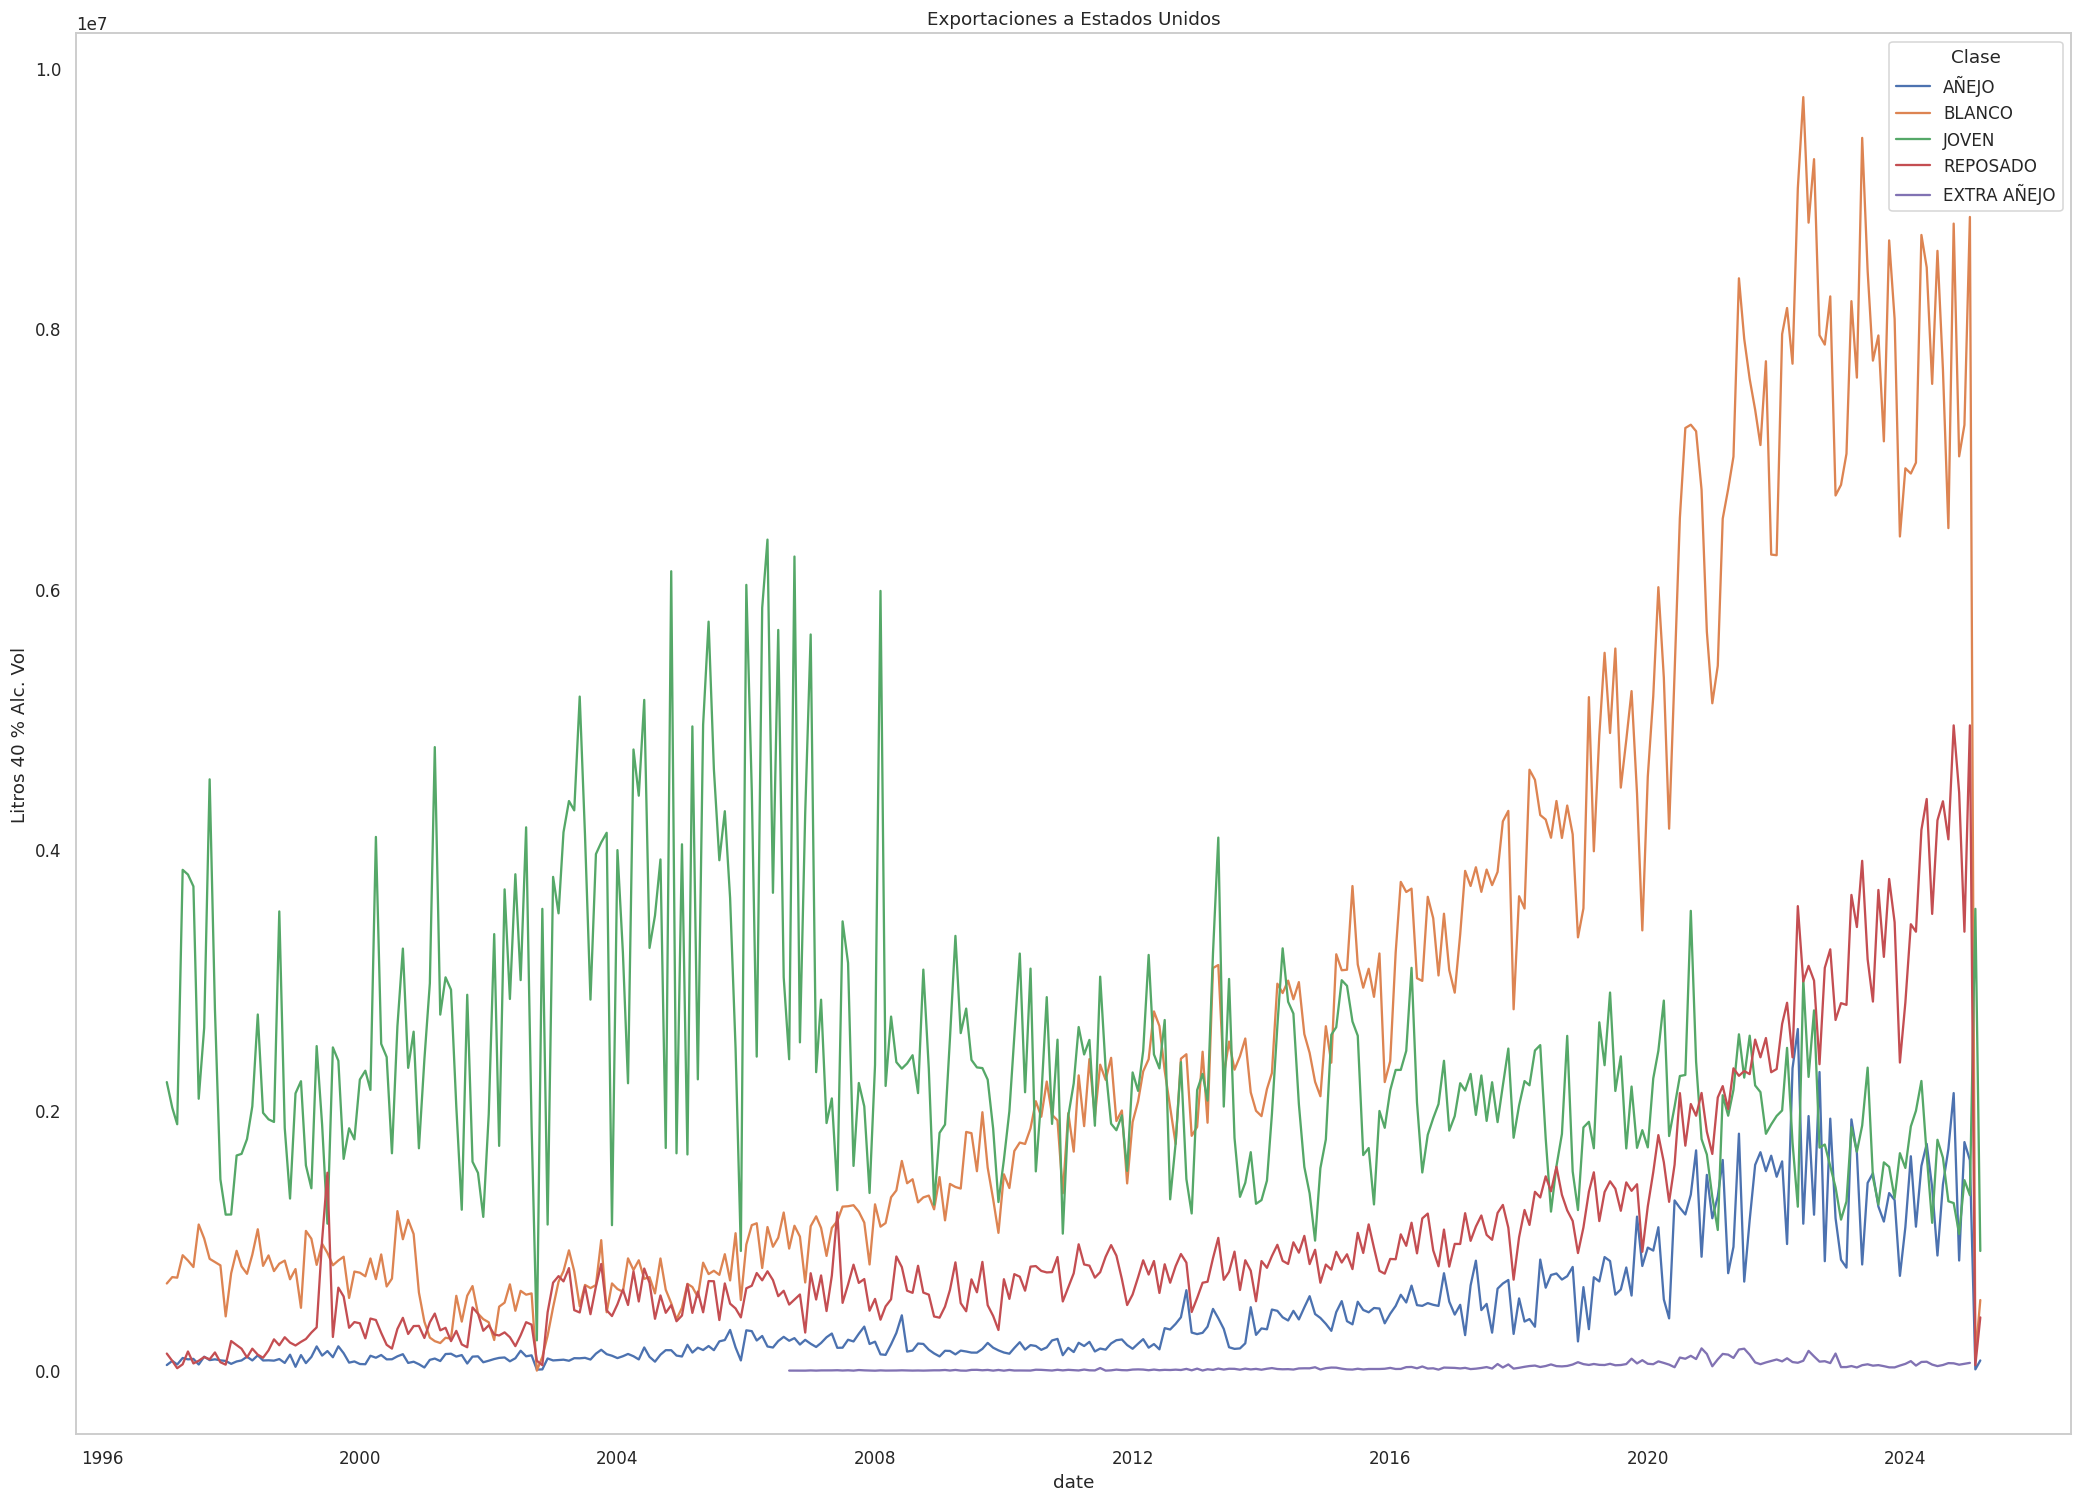

In [29]:
exportaciones_df = pd.read_csv(BASE_PATH / "consolidado_exportaciones_pais.csv")

exportaciones_df["date"] = exportaciones_df["AñoArchivo"].astype(str) + "-" + exportaciones_df["Mes"].astype(str) + "-1"
exportaciones_df["date"] = exportaciones_df["date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


dfWithoutTotals = exportaciones_df[(exportaciones_df["Categoria"] != "Total") & (exportaciones_df["NombrePais"] == "ESTADOS UNIDOS DE AMERICA")]

plt.figure(figsize=(11.7 * 2, 8.27 * 2))
plt.title('Exportaciones por subcategoría')

ax = sns.lineplot(data=dfWithoutTotals, x="date", y="Litros 40 % Alc. Vol", hue="Clase", errorbar=None)
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.grid()
ax.set_title("Exportaciones a Estados Unidos")

plt.show()


# Exportaciones por categoría

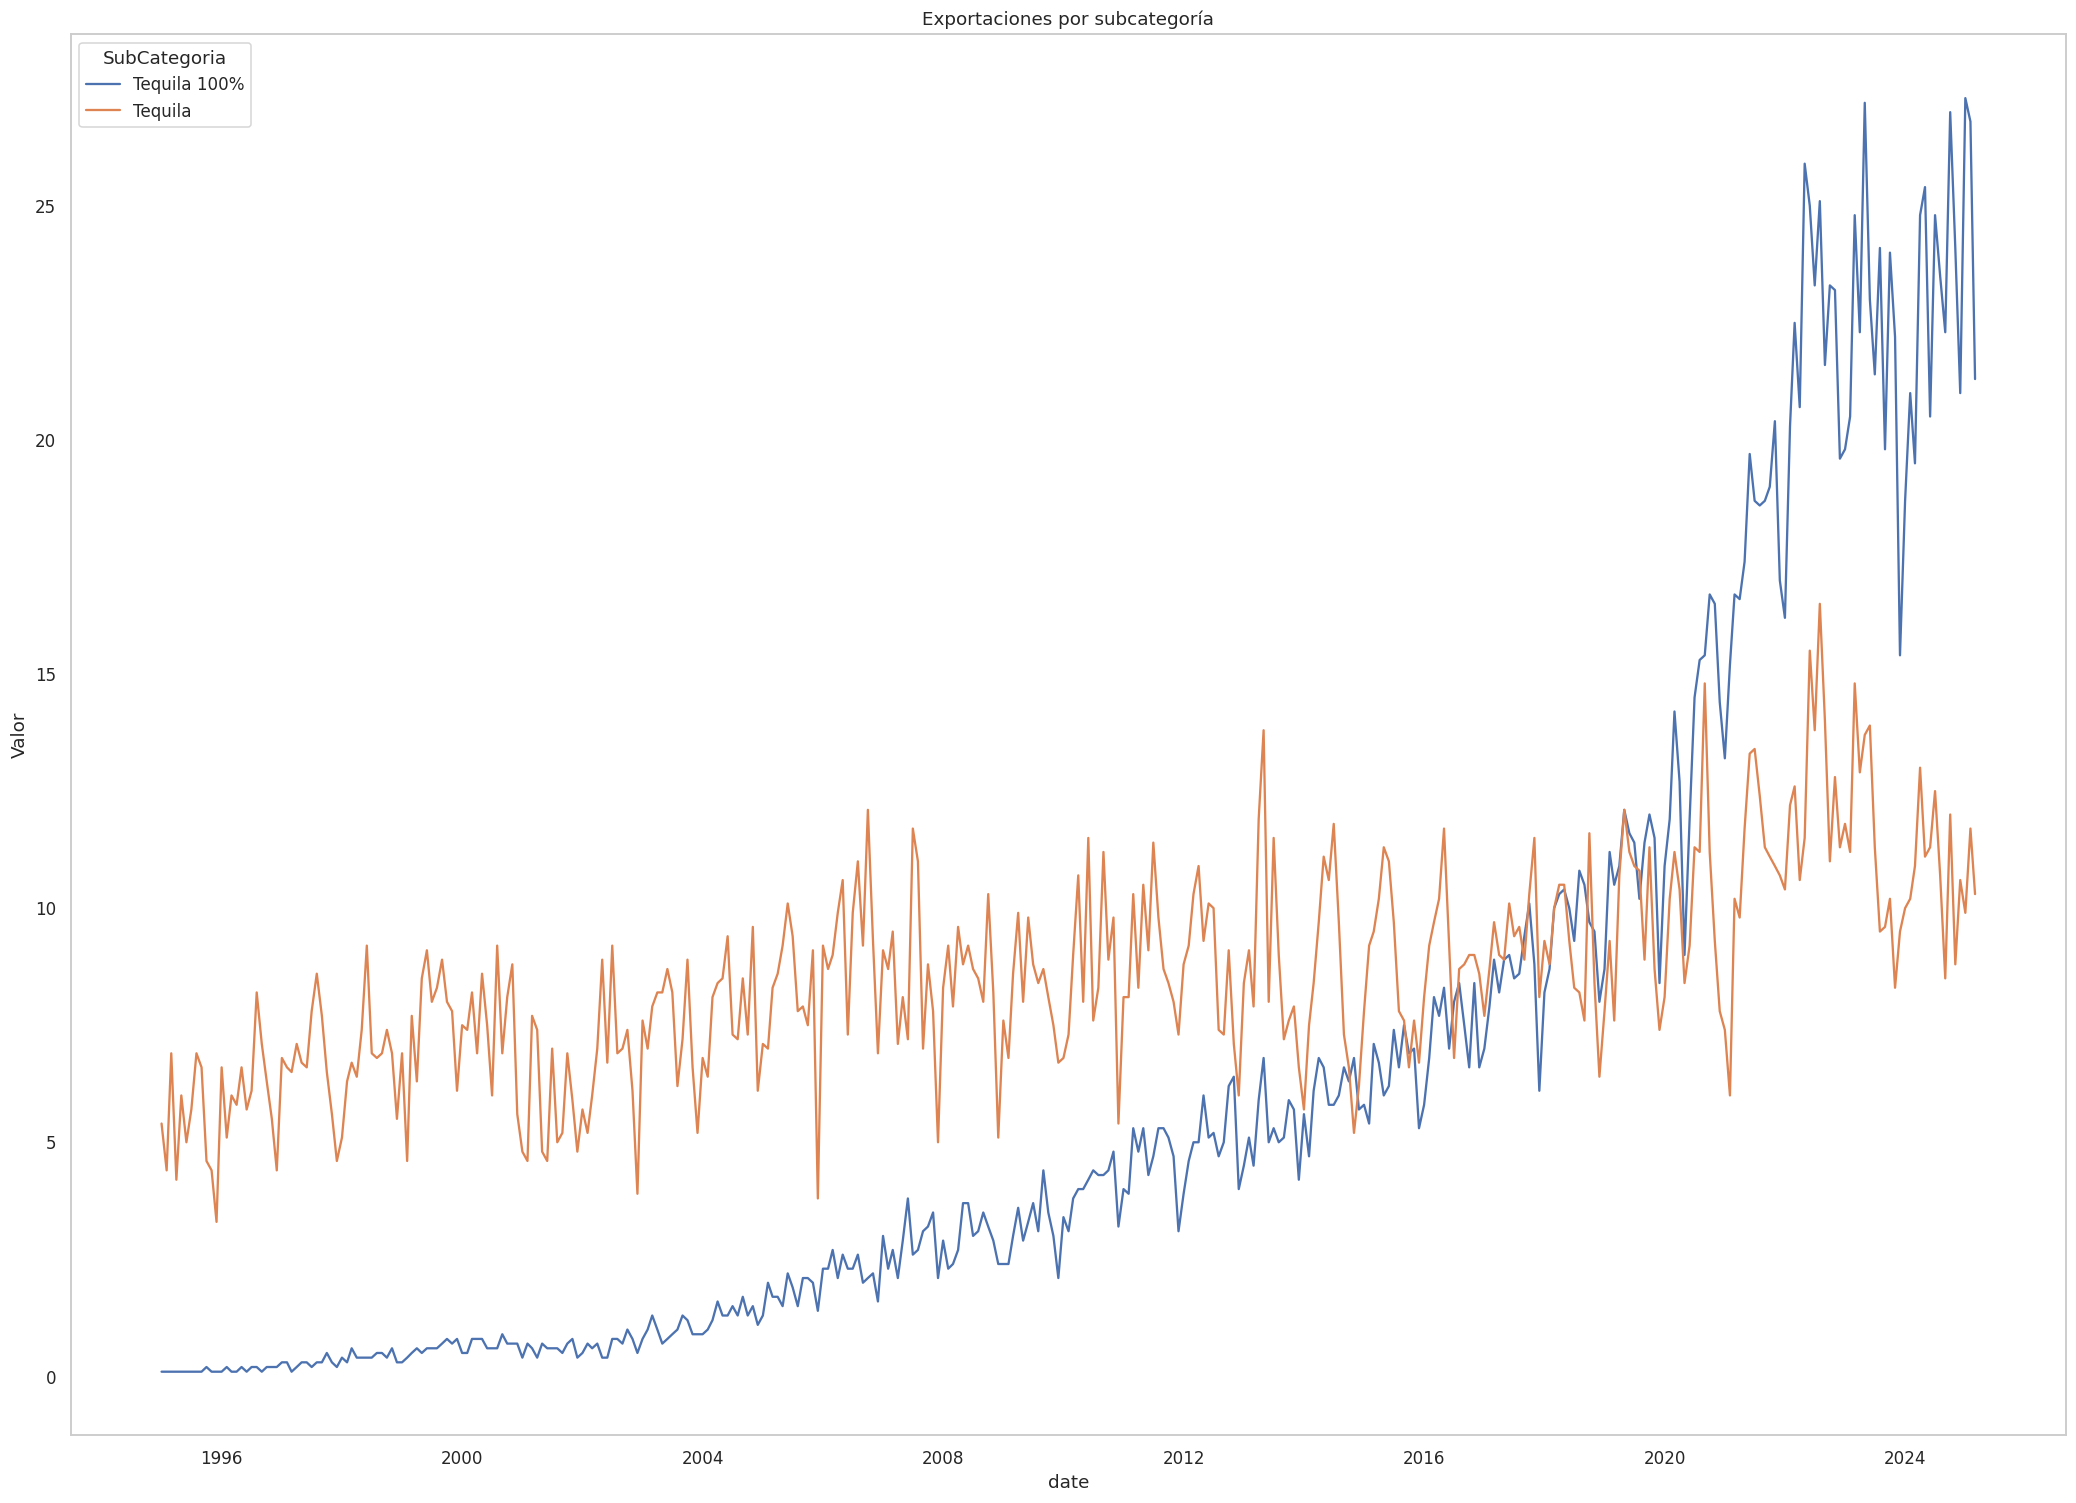

In [30]:
exportaciones_cat_df = pd.read_csv(BASE_PATH / "consolidado_exportacionestotalcategoria.csv")

exportaciones_cat_df["date"] = exportaciones_cat_df["AñoArchivo"].astype(str) + "-" + exportaciones_cat_df["Mes"].astype(str) + "-1"
exportaciones_cat_df["date"] = exportaciones_cat_df["date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))

plt.figure(figsize=(11.7 * 2, 8.27 * 2))
plt.title('Exportaciones por subcategoría')

loc = mdates.AutoDateLocator()
ax = sns.lineplot(data=exportaciones_cat_df[exportaciones_cat_df["SubCategoria"] != "Total"], x="date", y="Valor", hue="SubCategoria")
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.grid()

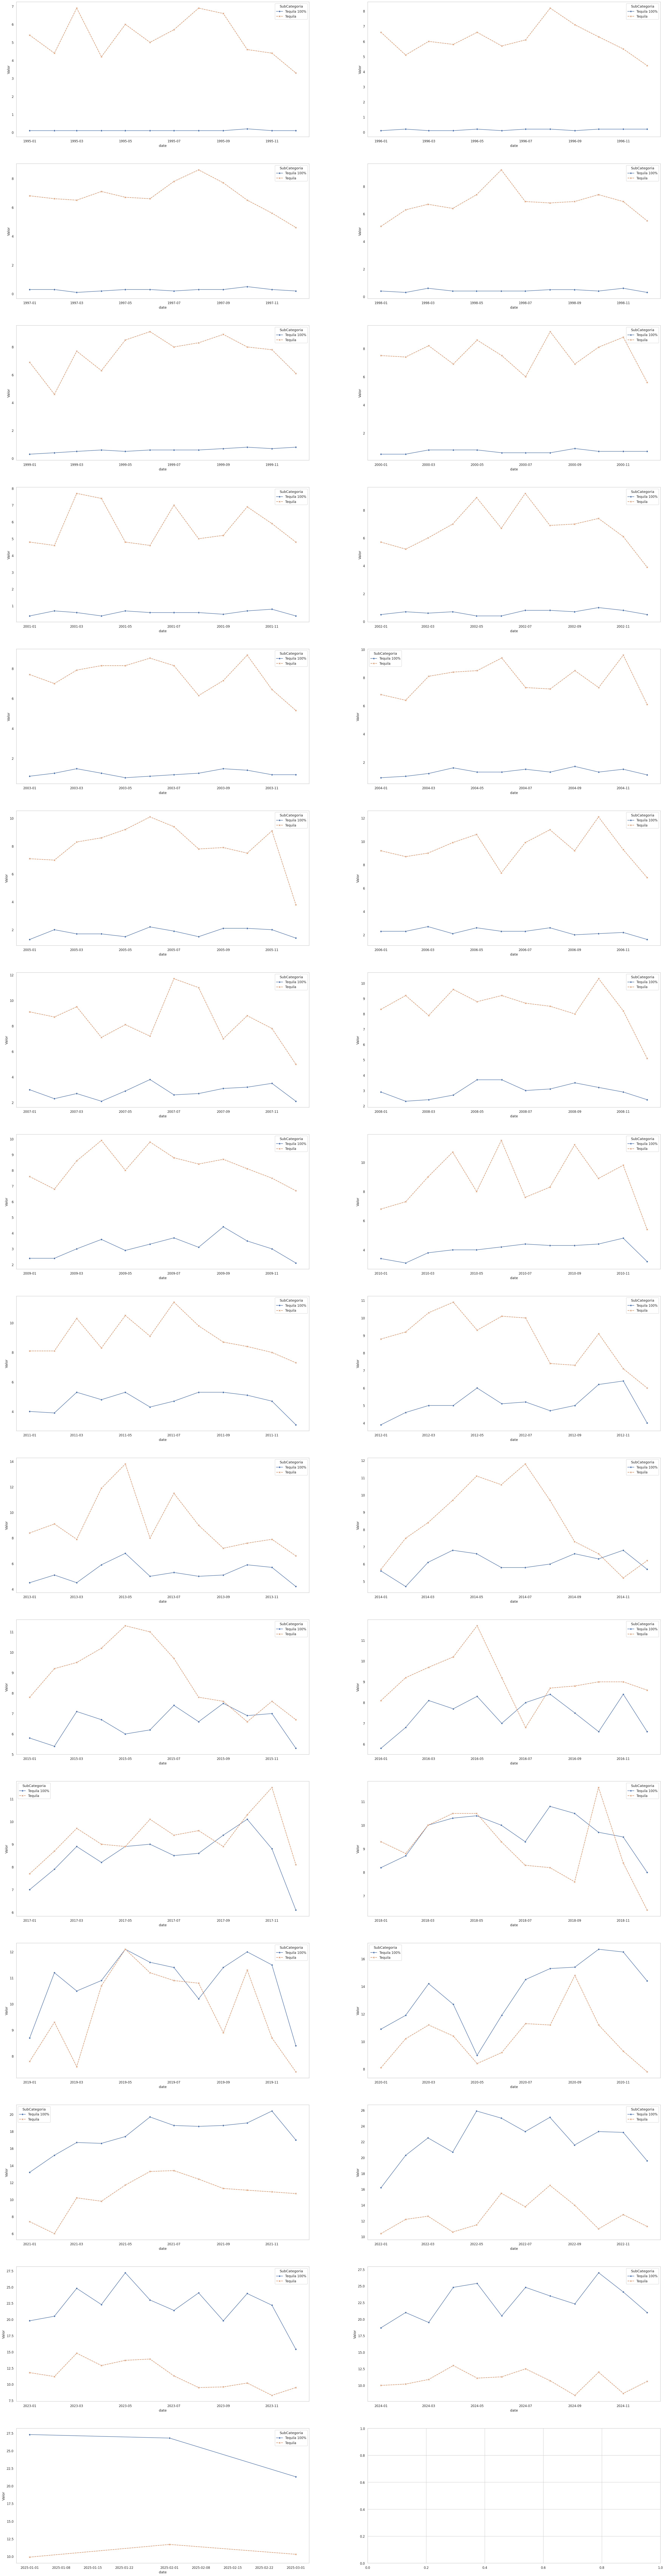

In [31]:
dfWithoutTotals = exportaciones_cat_df[exportaciones_cat_df["SubCategoria"] != "Total"]

cols = dfWithoutTotals["Year"].unique().tolist()
totalPlotColumns = 2
totalPlotRows = math.ceil(len(cols) / totalPlotColumns)
i = 0
j = 0
fig, axes = plt.subplots(totalPlotRows, totalPlotColumns, figsize=(20 * totalPlotColumns, 10 * totalPlotRows))

for indx, year in enumerate(cols):
    i = math.floor(((indx) / totalPlotColumns))
    j = indx % totalPlotColumns
    sns.lineplot(data=dfWithoutTotals[dfWithoutTotals["Year"] == year], x="date", y="Valor", hue="SubCategoria", style="SubCategoria", markers=True, ax=axes[i, j])
    loc = mdates.AutoDateLocator()
    axes[i, j].xaxis.set_major_locator(loc)
    axes[i, j].xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    axes[i, j].grid()


# Consumo de Agave

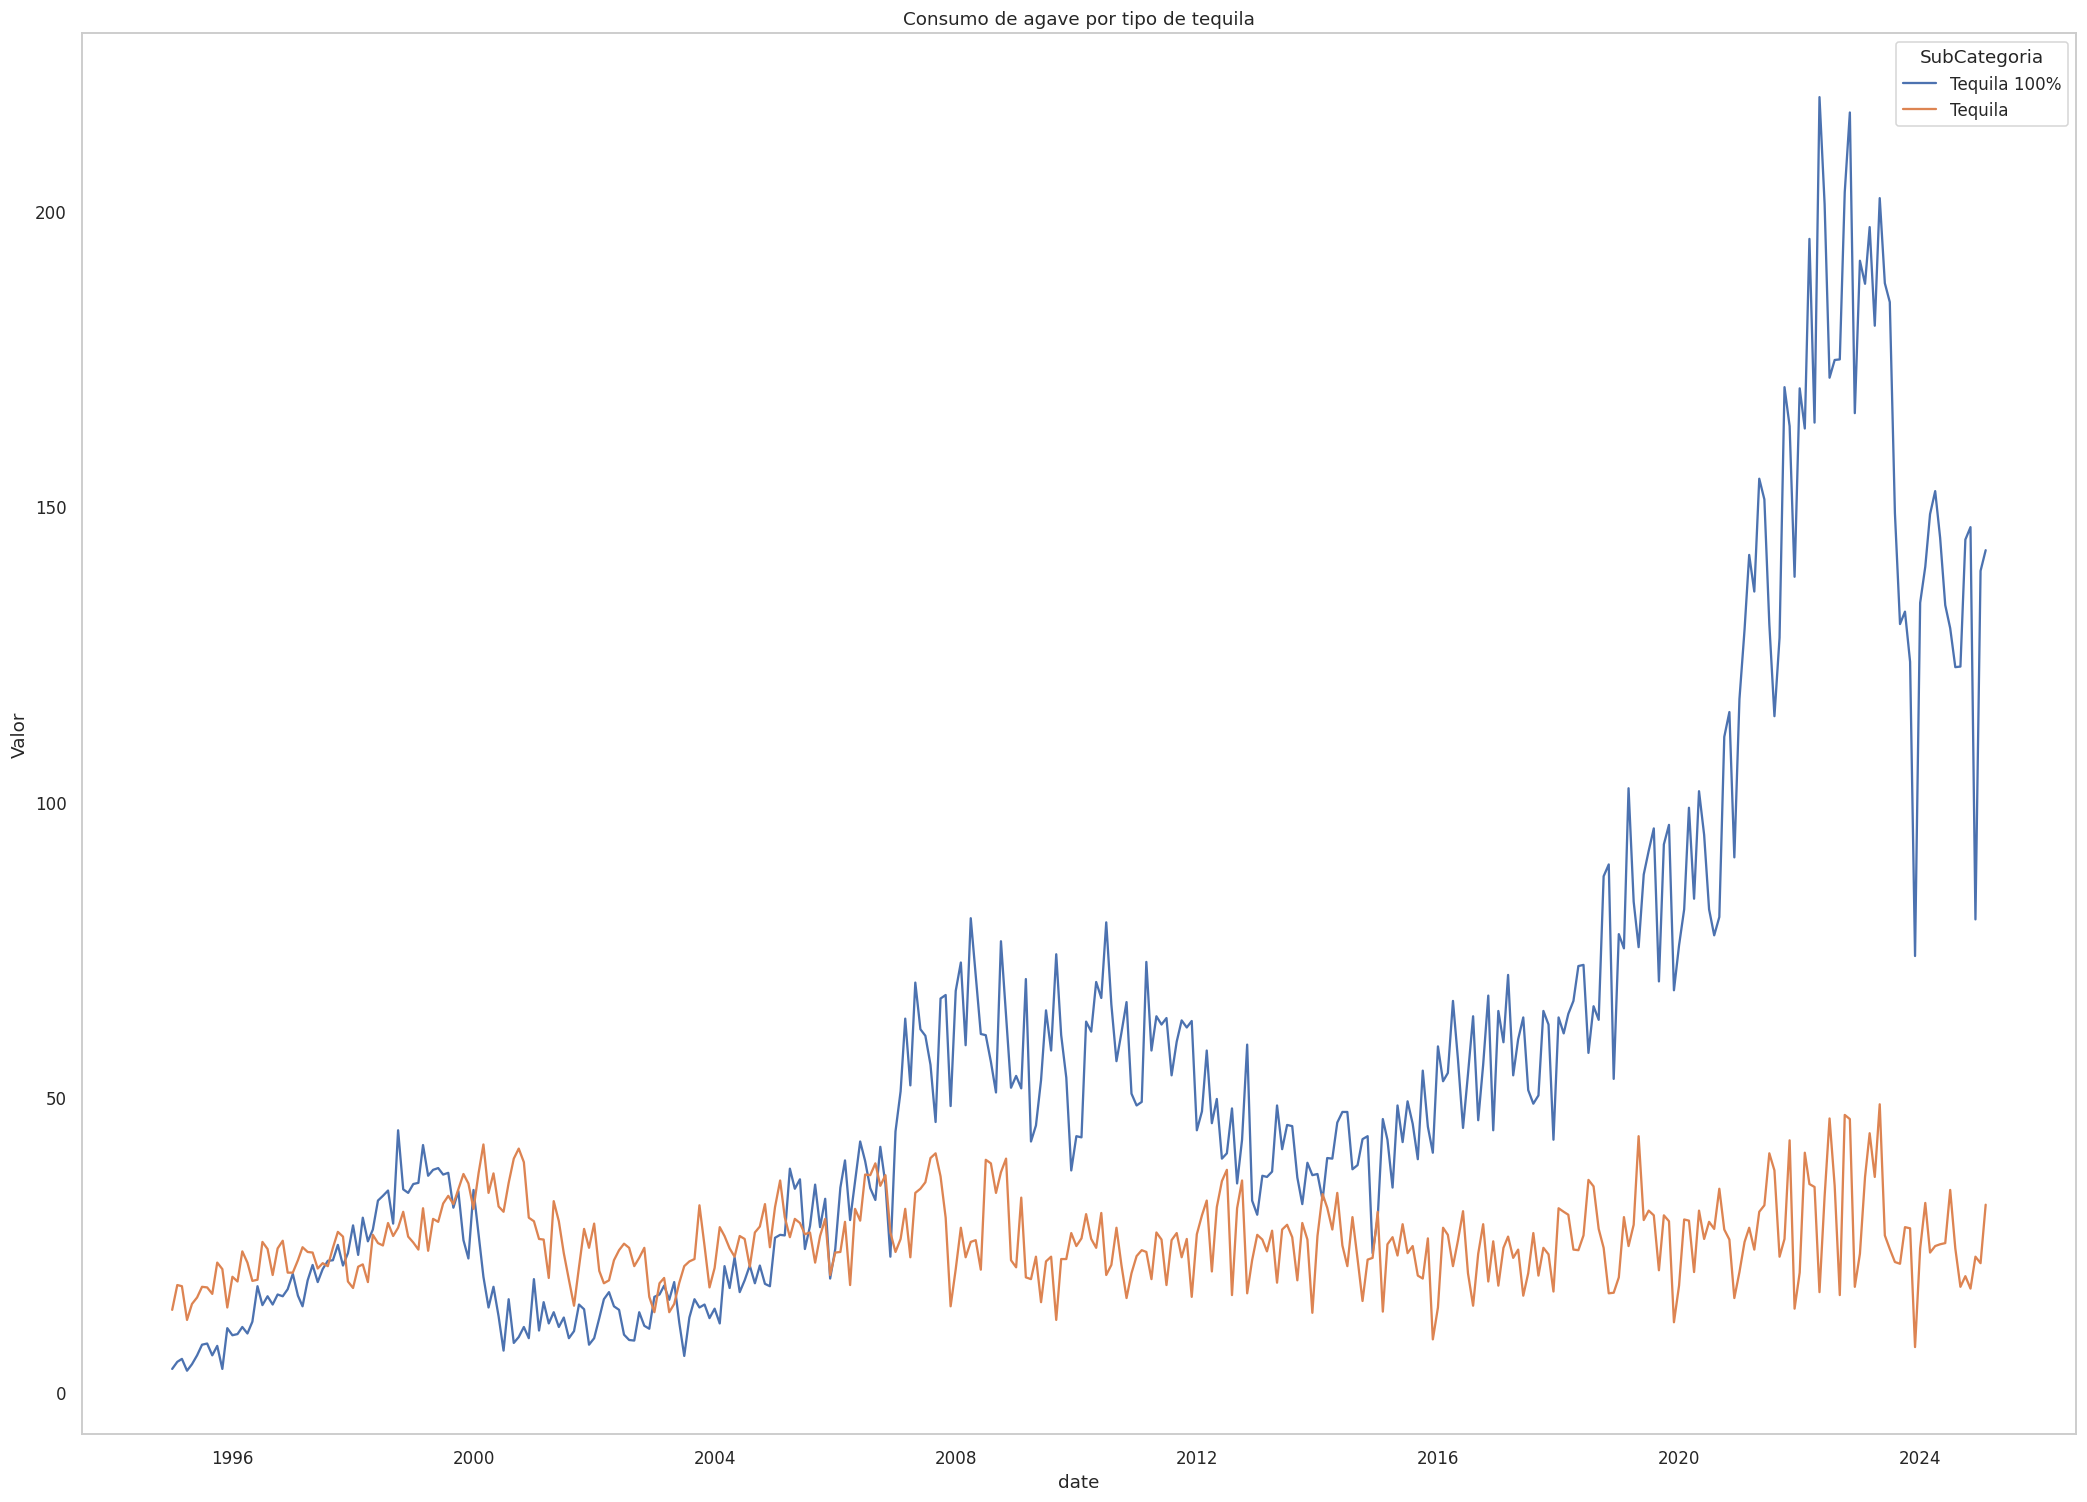

In [32]:
consumo_agave_df = pd.read_csv(BASE_PATH / "consolidado_consumodeagavetotal.csv")

consumo_agave_df["date"] = consumo_agave_df["Year"].astype(str) + "-" + consumo_agave_df["Mes"].astype(str) + "-1"
consumo_agave_df["date"] = consumo_agave_df["date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
consumo_agave_df["month"] = consumo_agave_df["date"].map(lambda x: x.strftime("%b"))
dfWithoutTotals = consumo_agave_df[consumo_agave_df["SubCategoria"] != "Total"]

plt.figure(figsize=(11.7 * 2, 8.27 * 2))
plt.title('Consumo de agave por tipo de tequila')

ax =  sns.lineplot(data=dfWithoutTotals, x="date", y="Valor", hue="SubCategoria")
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.grid()


# Consumo de Agave y Producción de Tequila

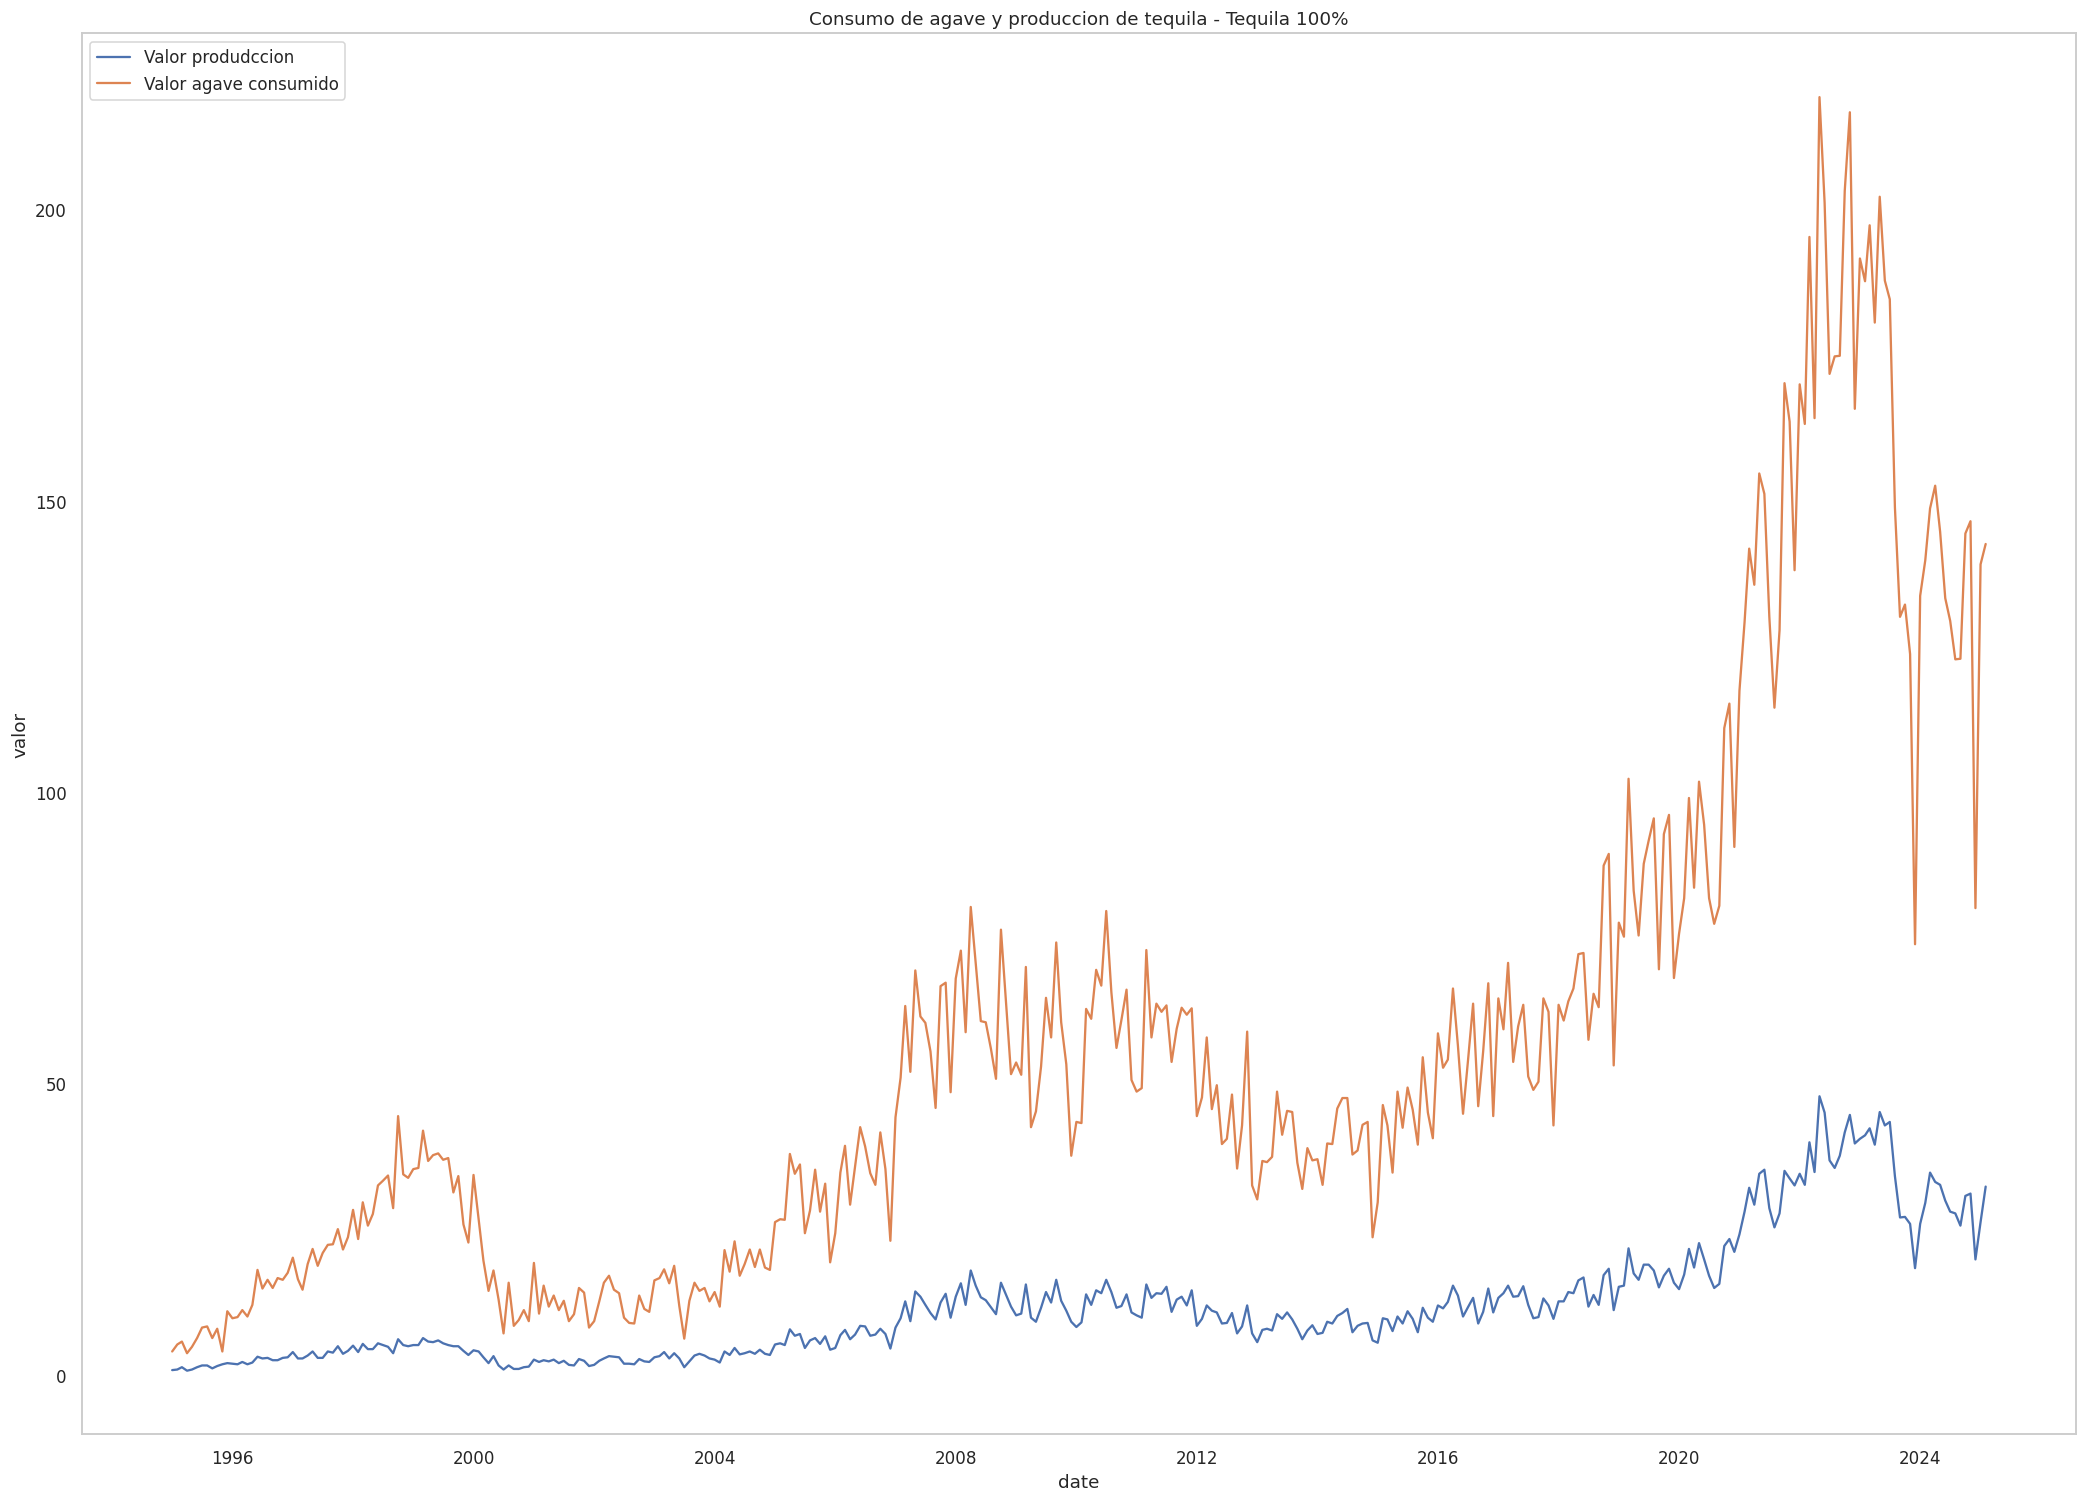

In [33]:
df_produccion = pd.read_csv(BASE_PATH / "../data/consolidado_producciontotaltequila.csv")
consumo_agave_df = pd.read_csv(BASE_PATH / "../data/consolidado_consumodeagavetotal.csv")

df_produccion["date"] = df_produccion["Year"].astype(str) + "-" + df_produccion["Mes"].astype(str) + "-1"
df_produccion["date"] = df_produccion["date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d')) # pd.to_datetime(df_produccion["date"], format='%Y-%m-%d')


consumo_agave_df["date"] = consumo_agave_df["Year"].astype(str) + "-" + consumo_agave_df["Mes"].astype(str) + "-1"
consumo_agave_df["date"] = consumo_agave_df["date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d')) # pd.to_datetime(df_produccion["date"], format='%Y-%m-%d')

df_produccion["key"] = df_produccion["date"].astype(str) + "-" + df_produccion["SubCategoria"]
consumo_agave_df["key"] = consumo_agave_df["date"].astype(str) + "-" + consumo_agave_df["SubCategoria"]

df_prod_consumo = df_produccion.merge(
    consumo_agave_df, on="key", suffixes=("_prod", "_agave")
)

df_prod_consumo = df_prod_consumo.drop(
    axis=1,
    labels=[
        "key",
        "Year_agave",
        "SubCategoria_agave",
        "AñoArchivo_agave",
        "Mes_agave",
        "date_agave",
        'AñoArchivo_prod'
    ],
)

df_prod_consumo = df_prod_consumo.rename(
    columns={"SubCategoria_prod": "SubCategoria", "Year_prod": "Year", "Mes_prod": "Mes", "date_prod":"date"}
)


dfWithoutTotals = df_prod_consumo[df_prod_consumo["SubCategoria"] != "Total"]
dfWithoutTotals = dfWithoutTotals[dfWithoutTotals["SubCategoria"] == "Tequila 100%"]

plt.figure(figsize=(11.7 * 2, 8.27 * 2))

# Plot the lines
plt.plot(dfWithoutTotals["date"], dfWithoutTotals["Valor_prod"], label='Valor produdccion')
plt.plot(dfWithoutTotals["date"], dfWithoutTotals["Valor_agave"], label='Valor agave consumido')

# Add labels and title
plt.xlabel('date')
plt.ylabel('valor')
plt.title('Consumo de agave y produccion de tequila - Tequila 100%')
plt.legend()  # Add a legend to distinguish the lines


loc = mdates.AutoDateLocator()
ax = plt.gca()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.grid()
# axes[i, j].xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
# axes[i, j].grid()

# Show the plot
plt.show()

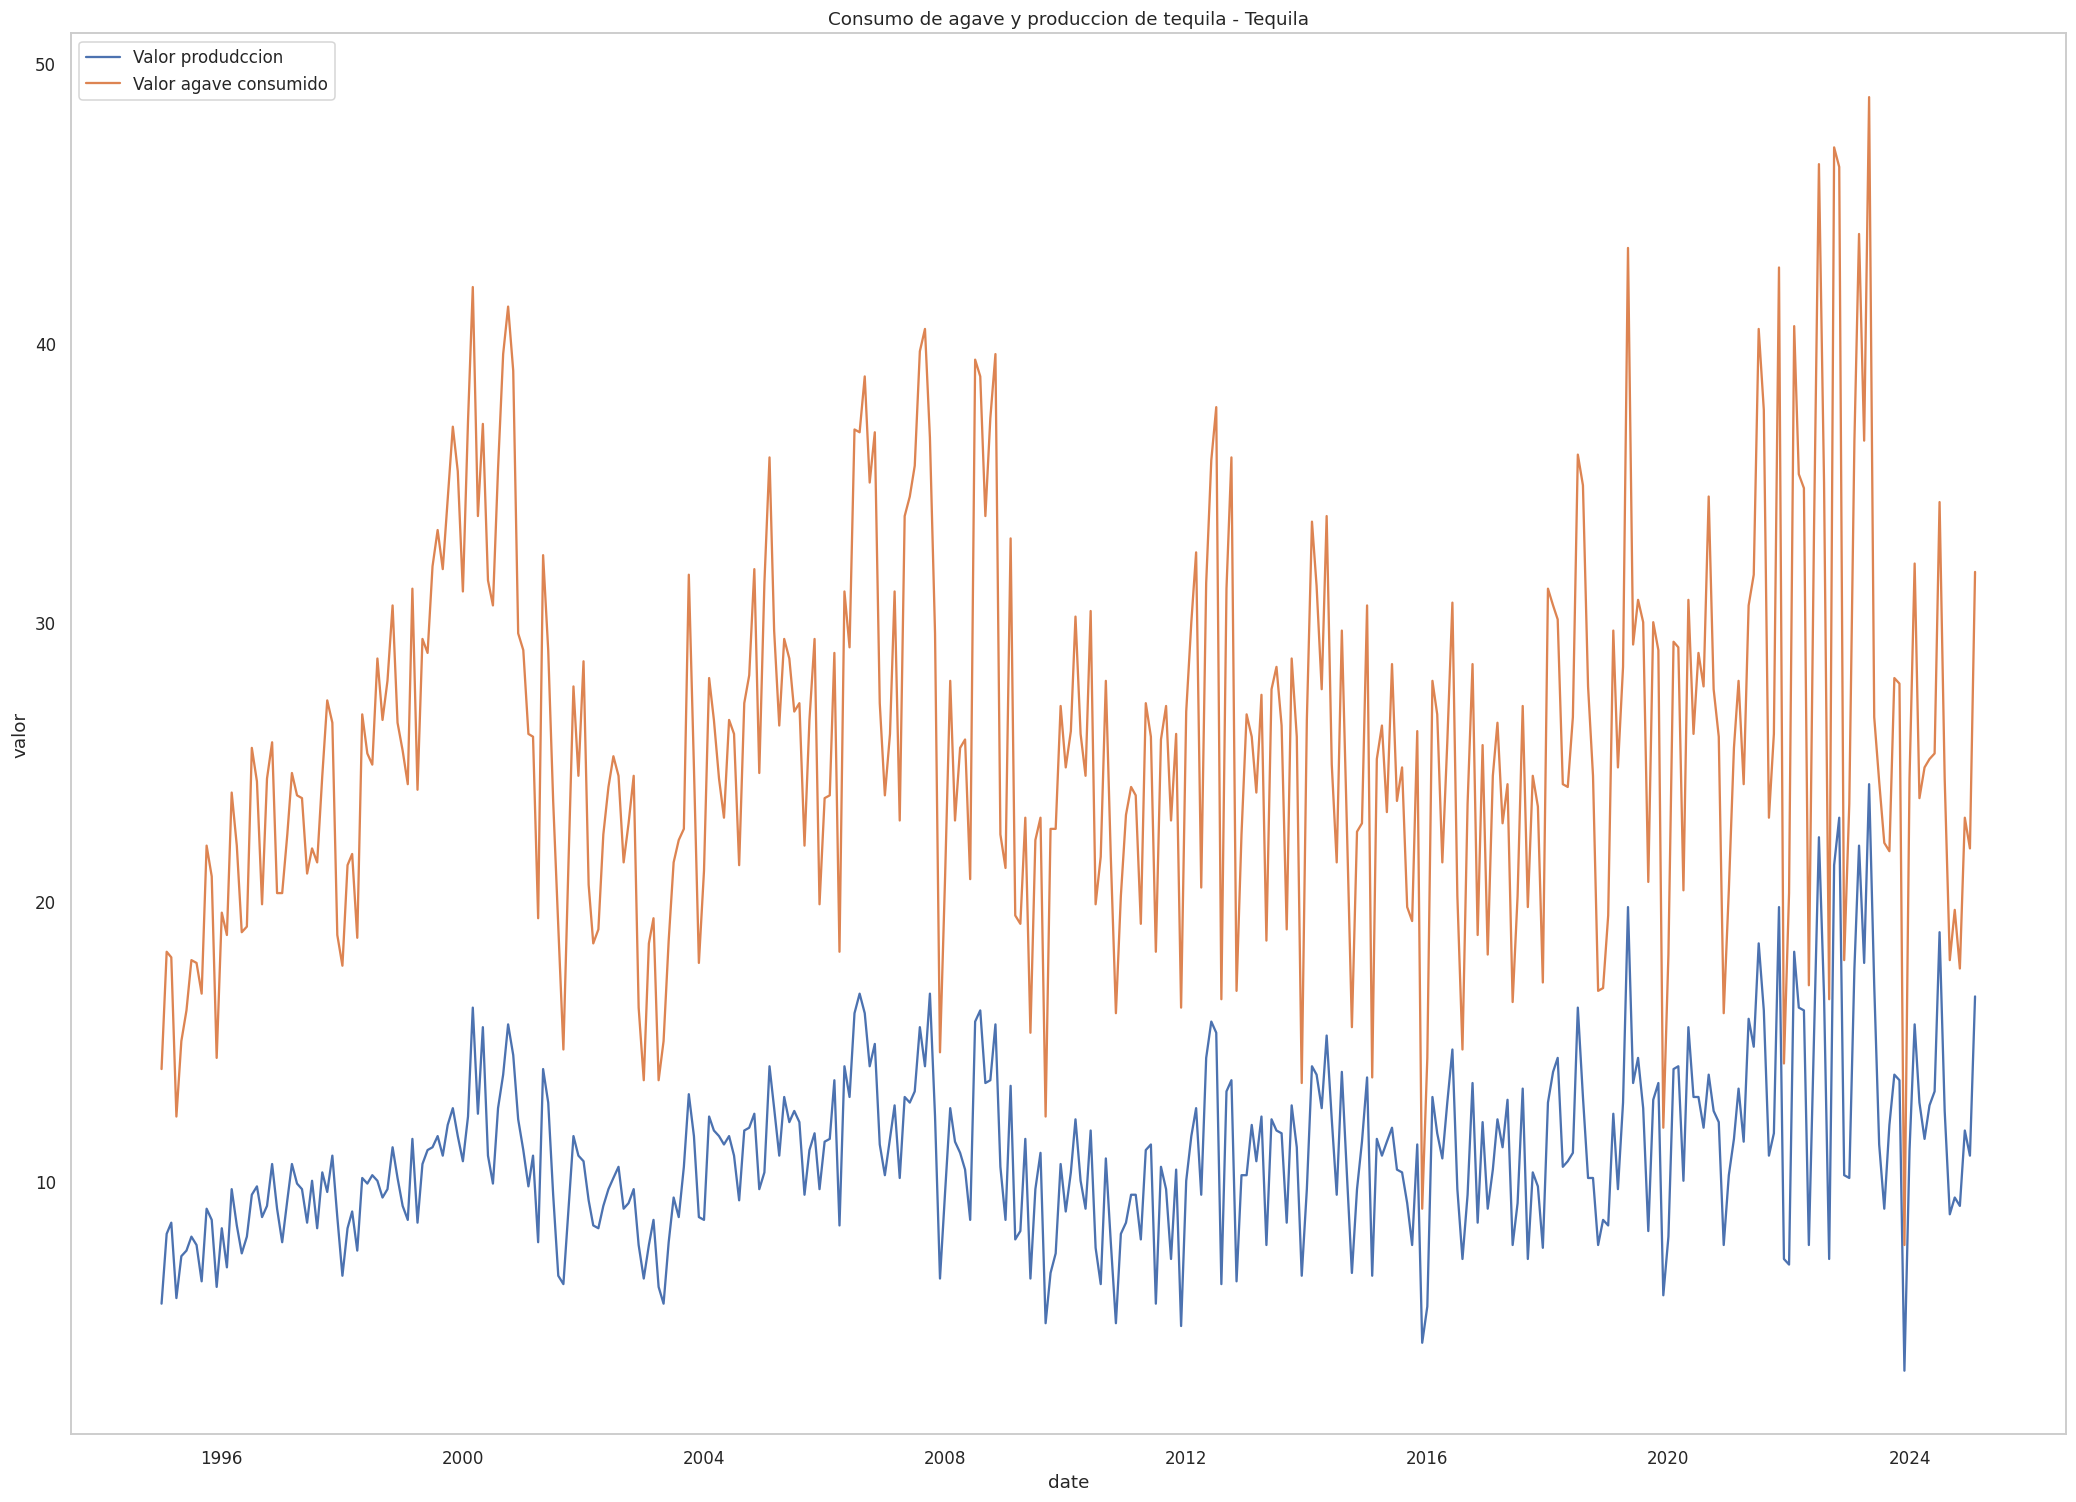

In [34]:
dfWithoutTotals = df_prod_consumo[df_prod_consumo["SubCategoria"] != "Total"]
dfWithoutTotals = dfWithoutTotals[dfWithoutTotals["SubCategoria"] == "Tequila"]

plt.figure(figsize=(11.7 * 2, 8.27 * 2))

# Plot the lines
plt.plot(dfWithoutTotals["date"], dfWithoutTotals["Valor_prod"], label='Valor produdccion')
plt.plot(dfWithoutTotals["date"], dfWithoutTotals["Valor_agave"], label='Valor agave consumido')

# Add labels and title
plt.xlabel('date')
plt.ylabel('valor')
plt.title('Consumo de agave y produccion de tequila - Tequila')
plt.legend()  # Add a legend to distinguish the lines


loc = mdates.AutoDateLocator()
ax = plt.gca()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.grid()

# Show the plot
plt.show()

# Exportaciones por forma

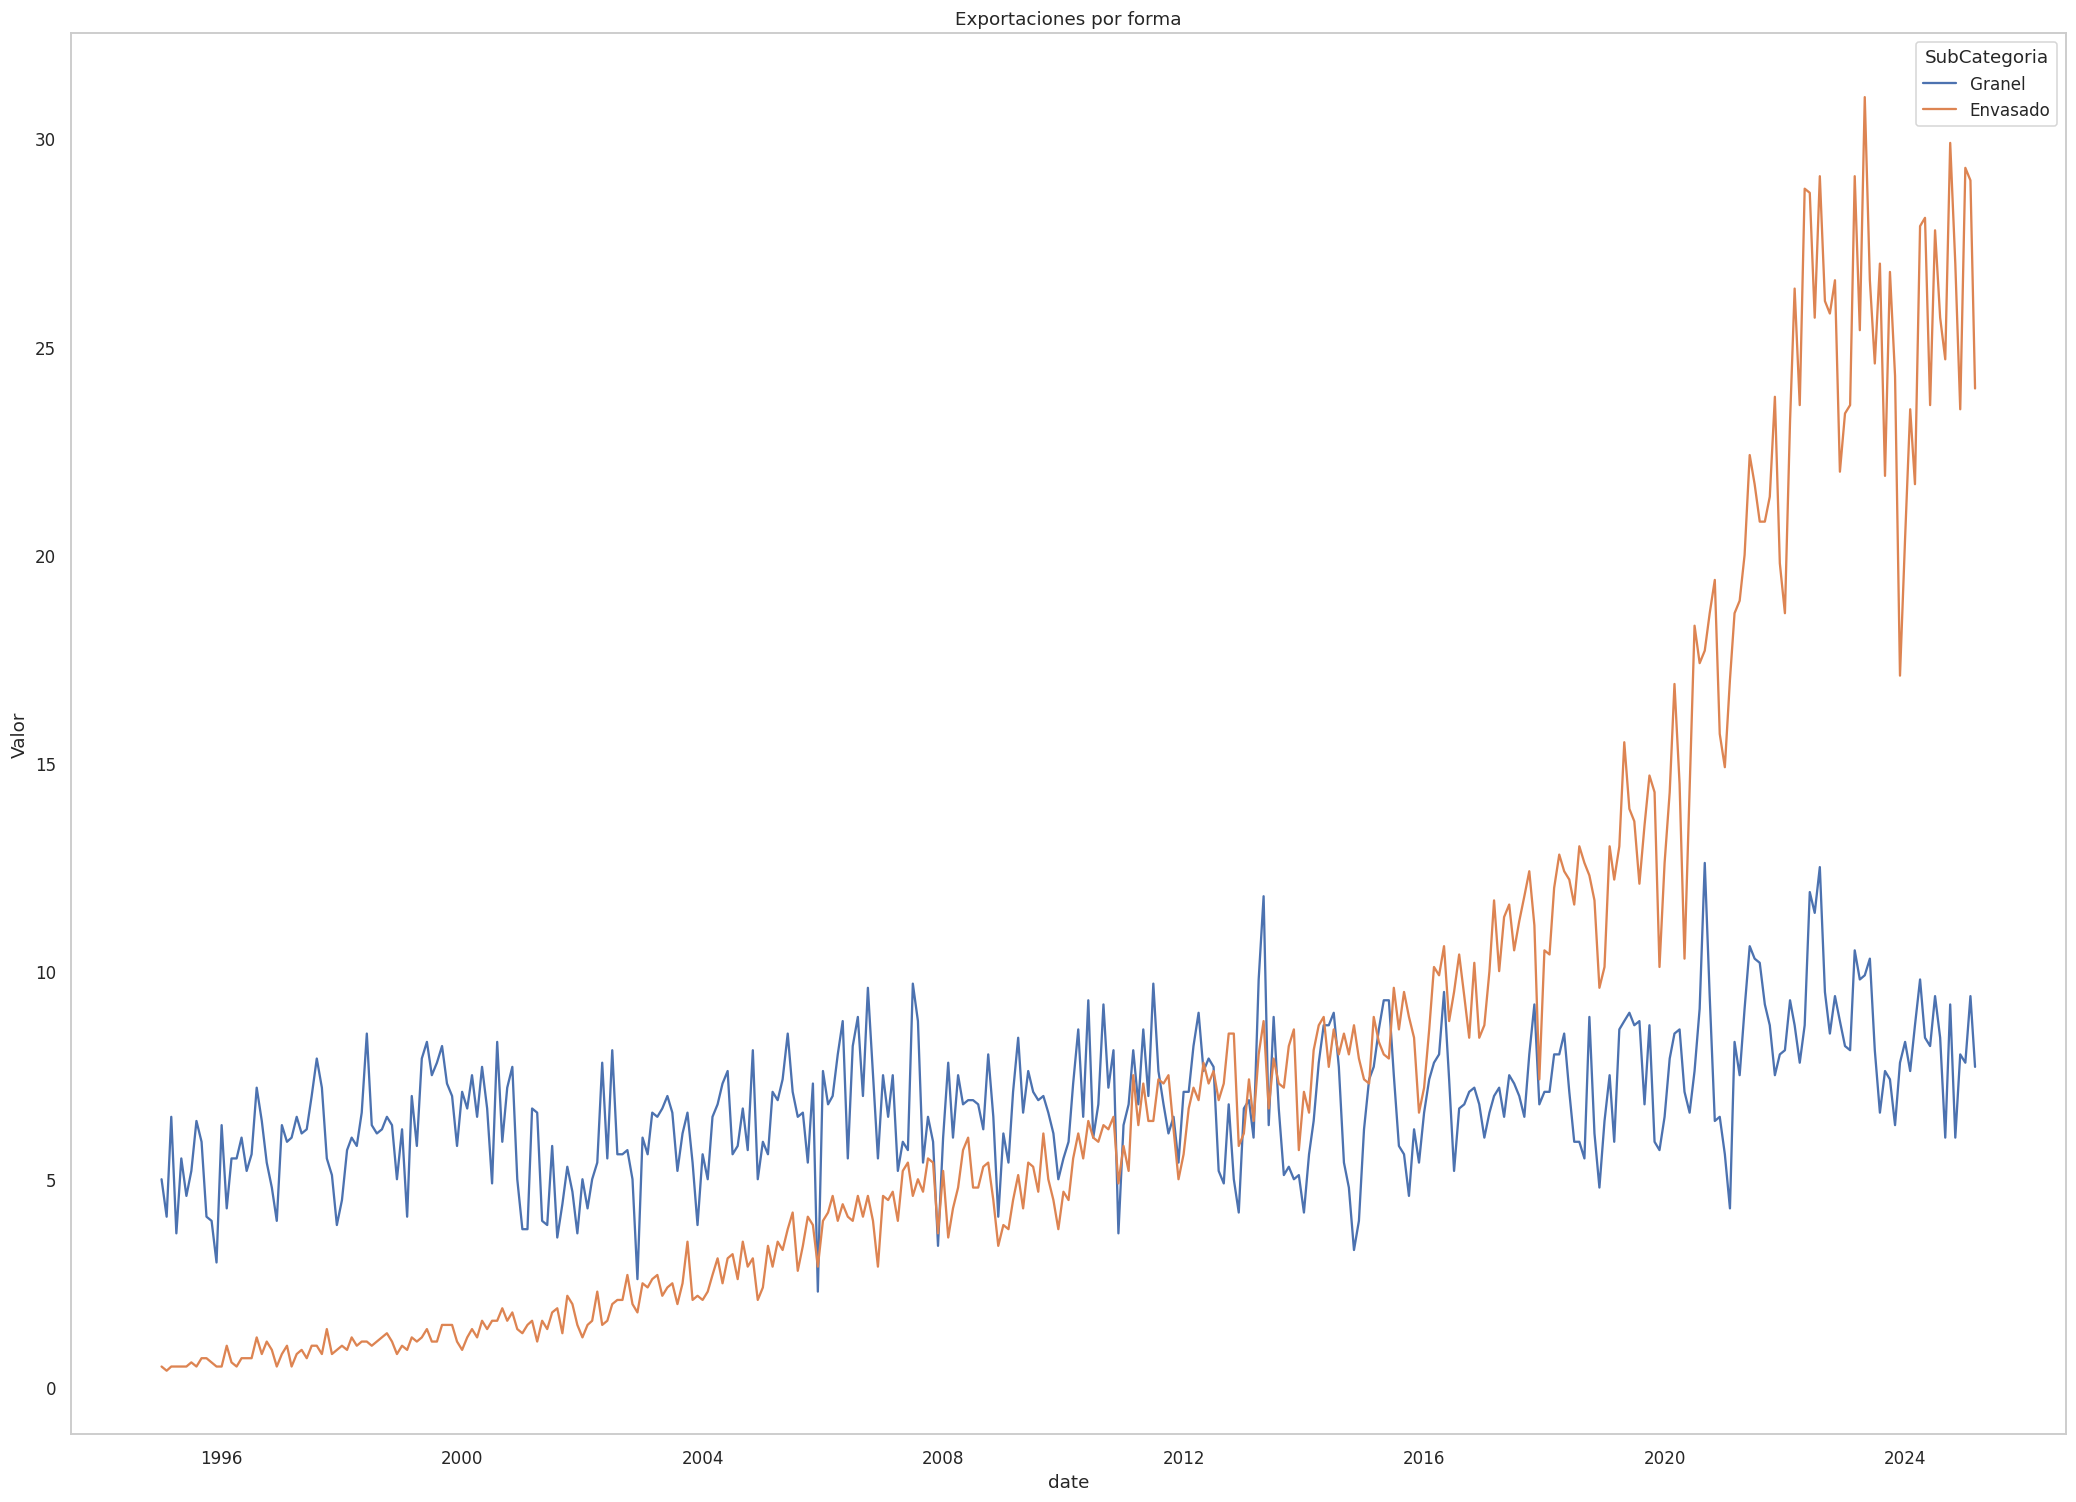

In [35]:
exportaciones_df = pd.read_csv(BASE_PATH / "../data/consolidado_exportacionestotalforma.csv")


exportaciones_df["date"] = exportaciones_df["Year"].astype(str) + "-" + exportaciones_df["Mes"].astype(str) + "-1"
exportaciones_df["date"] = exportaciones_df["date"].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


plt.figure(figsize=(11.7 * 2, 8.27 * 2))
plt.title('Exportaciones por forma')

loc = mdates.AutoDateLocator()
ax = sns.lineplot(data=exportaciones_df[exportaciones_df["SubCategoria"] != "Total"], x="date", y="Valor", hue="SubCategoria")
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.grid()


# Producción vs Consumo del Tequila

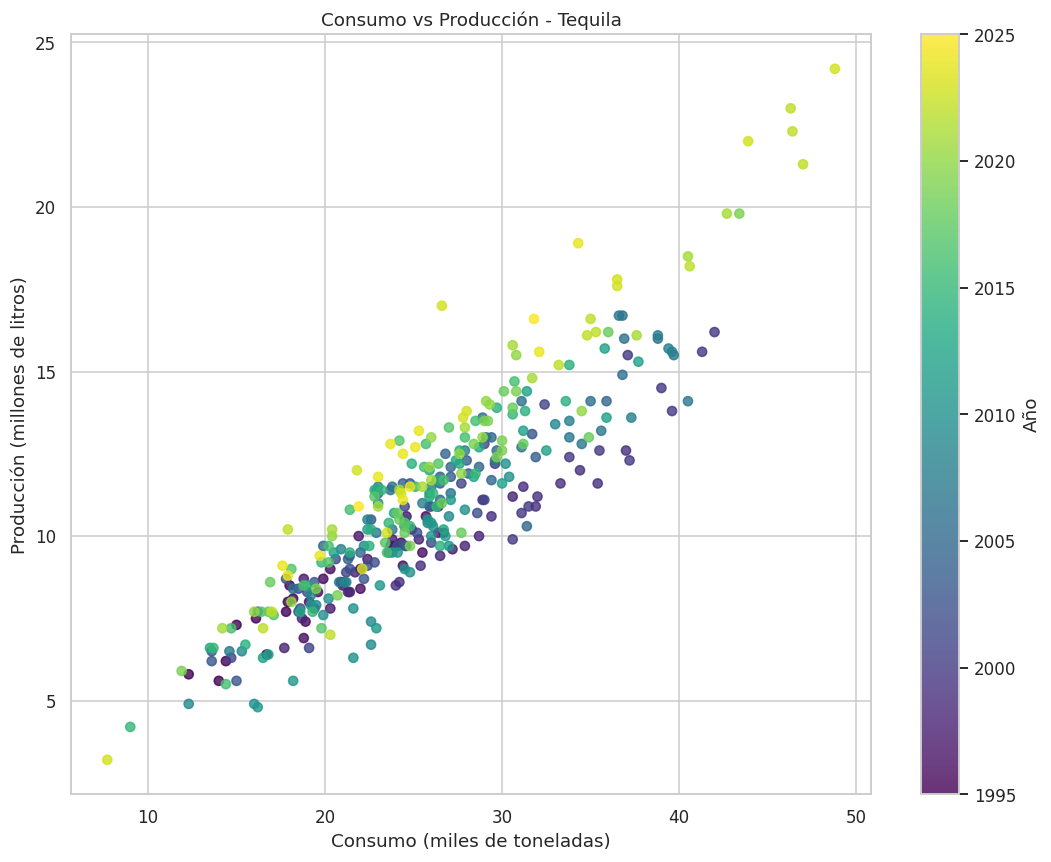

In [36]:
# Filtrar por categoría "Tequila"
df_tequila = df_prod_consumo[df_prod_consumo["SubCategoria"] == "Tequila"]

# Crear gráfico de dispersión
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_tequila["Valor_agave"],
    df_tequila["Valor_prod"],
    c=df_tequila["Year"],
    cmap="viridis",
    alpha=0.8,
    vmin=df_prod_consumo["Year"].min(),
    vmax=df_prod_consumo["Year"].max()
)

# Etiquetas y barra de color
plt.xlabel("Consumo (miles de toneladas)")
plt.ylabel("Producción (millones de litros)")
plt.title("Consumo vs Producción - Tequila")
cbar = plt.colorbar(scatter)
cbar.set_label("Año")
plt.grid(True)
plt.tight_layout()
plt.show()